<a href="https://colab.research.google.com/github/BecomeAllan/ML-SLRC/blob/main/book/Meta_learning_EFL_book.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Trabalho de execução do Notebook ⏰

    Allan = mpnet (sentence)
    Flavio = obert
    Arthur = Scibert


  Ordem de execução do trabalho ((celula) @Executrar):
  
+ @🌊 -> @🌏⚡:
  + -> 🎁 -> @🎫 -> @📚 -> (SAVE THE MODEL) -> @📗: 

  + -> 🎁 (50-50) -> @🛸:
    + Ablation (size model): Sempre troque o [tamanho do modelo em:](https://colab.research.google.com/drive/10ibrKXuOm3faAO0fSOIibBv28w4TQnOK?authuser=3#scrollTo=28u2y4iieUrk&line=3&uniqifier=1)


```
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tentativa_do_ablation = 0 ## TROCAR AQUI QUAL VAI SER A QUANTIDADE DE LAYERS conforme em ablation = {...}
Info["bert_layers"] = ablation['bert_layers'][tentativa_do_ablation]

# SLR classifier model
model_ablation = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
...
```

Salve os modelos depois de 📚 para não perder o modelo e conseguir rodar separadamente os datasets na pipeline depois (sem ter que passar pelo processo de treinar no meta-learning). Quando estiver preparado para rodar o notebook e salvar os modelos, mude as configurações do `Info` na celula 📚. 


```
## Saving model after 📚 on 🎁
torch.save(model.state_dict(), model_path)

## Loading

# Config the model that was saved
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )

model.state_dict(torch.load(model_path))

```




É importante saber que as execuções demoram, logo pode cair o colab. A execução de 📗 e 🛸 tem vários attemps e datasets, logo, é possível separar os datasets ao computar a pipeline `pipeline_simulation(names_to_valid = names_to_valid[4:6])` no qual a variável `names_to_valid` deve ser uma lista. O que mais demora é o modelo fazer a inferência em cada dataset, se houver espaço na GPU, troque o `batch_test= 100` na pipeline_simulation


**Obs.:** Ao terminar a execução de cada attempt, o notebook salva os resultados em `./Results/...`. Nesta pasta haverá um arquivo `metrics.csv` no respectivo 🎁 ou 🛸 executado, e possui uma pasta com o nome dos banco de dados testados com suas respectivas imagens, sempre que puder, exporte a pasta `./Results/`.

---

---







# Introduction

This notebook was used to conduct a research of a agnostic-model for systematics literatures reviews classification, using [Entailment as Few-shot classification](https://arxiv.org/abs/2104.14690) and [first-order meta-learning algorithms](https://arxiv.org/abs/1803.02999) with a pre-trained language model [SciBERT](https://arxiv.org/abs/1903.10676).

The etailment text used was "It is a great text.".

## Requirements

In [1]:
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!pip install wandb -qU

# !pip install sparsezoo
!pip install matplotlib==3.5.1
# !pip install onnx2torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 52.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 18.7 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=de24c8d8e9f22d077e3b86a6ca622cfde7a504a95e327252c182526138a99d09
  Stored in directory: /root/.cache/pip/wheels/82/ab/9b/c15899bf659ba74f623ac776e861cf2eb8608c1825ddec66a4
Successfully built sacremoses
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 KB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.1 MB

In [2]:
%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import numpy as np
import pandas as pd
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path

SEED = 2222

gen_seed = torch.Generator().manual_seed(SEED)

# 🌊 Useful Functions

Useful function to conduct the research

## Random


In [3]:
import random

# Random seed function
def random_seed(value):
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    np.random.seed(value)
    random.seed(value)

# Tasks for meta-learner
def create_batch_of_tasks(taskset, is_shuffle = True, batch_size = 4):
    idxs = list(range(0,len(taskset)))
    if is_shuffle:
        random.shuffle(idxs)
    for i in range(0,len(idxs), batch_size):
        yield [taskset[idxs[i]] for i in range(i, min(i + batch_size,len(taskset)))]


## Diagnosis

### Framework

In [4]:
# Prepare data to process by Domain-learner
def prepare_data(data, batch_size, tokenizer,max_seq_length,
                 input = 'text', output = 'label',
                 train_size_per_class = 5, global_datasets = False,
                 treat_text_fun =None):
  data = data.reset_index().drop("index", axis=1)

  if global_datasets:
    global data_train, data_test

  # Sample task for training
  data_train = data.groupby('label').sample(train_size_per_class, replace=False)
  idex = data.index.isin(data_train.index)

  # The Test set to label by the model
  data_test = data[~idex].reset_index()


  # Transform in dataset to model
  ## Train
  dataset_train = SLR_DataSet(
    data = data_train.sample(frac=1),
    input = input,
    output = output,
    tokenizer=tokenizer,
    max_seq_length =max_seq_length,
    treat_text =treat_text_fun)

  ## Test
  dataset_test = SLR_DataSet(
    data = data_test,
    input = input,
    output = output,
    tokenizer=tokenizer,
    max_seq_length =max_seq_length,
    treat_text =treat_text_fun)
  
  # Dataloaders
  ## Train 
  data_train_loader = DataLoader(dataset_train,
                           shuffle=True,
                          #  sampler = sampler,
                           batch_size=batch_size['train']
                            )
  ## Test
  if len(dataset_test) % batch_size['test'] == 1 :
    data_test_loader = DataLoader(dataset_test,
                                    batch_size=batch_size['test'],
                                    drop_last=True)
  else:
    data_test_loader = DataLoader(dataset_test,
                                    batch_size=batch_size['test'],
                                    drop_last=False)

  return data_train_loader, data_test_loader, data_train, data_test


In [54]:
from tqdm import tqdm

# Meta trainer
def meta_train(data, model, Info,
               print_epoch =True, size_layer=0,
                Test_resource =None,
                treat_text_fun =None):

  # Meta-learner model
  learner = Learner(model = model, **Info)
  
  # Testing tasks
  if isinstance(Test_resource, pd.DataFrame):
    test = MetaTask(Test_resource, num_task = 0, k_support=10, k_query=10,
                  training=False,treat_text =treat_text_fun, **Info)


  torch.clear_autocast_cache()
  gc.collect()
  torch.cuda.empty_cache()

  # Meta epoch (Outer epoch)
  for epoch in tqdm(range(Info['meta_epoch']), desc= "Meta epoch ", ncols=80):
      
      # Train tasks
      train = MetaTask(data,
                      num_task = Info['num_task_train'],
                      k_support=Info['k_qry'],
                      k_query=Info['k_spt'],
                      treat_text =treat_text_fun, **Info)

      # Batch of train tasks
      db = create_batch_of_tasks(train, is_shuffle = True, batch_size = Info["outer_batch_size"])

      if print_epoch:
      # Outer loop bach training
        for step, task_batch in enumerate(db):          
            print("\n-----------------Training Mode","Meta_epoch:", epoch ,"-----------------\n")
            
            # meta-feedfoward (outer-feedfoward)
            acc = learner(task_batch, valid_train= print_epoch)
            print('Step:', step, '\ttraining Acc:', acc)
        
        if isinstance(Test_resource, pd.DataFrame):
          # Validating Model
          if ((epoch+1) % 4) + step == 0:
              random_seed(123)
              print("\n-----------------Testing Mode-----------------\n")
              
              # Batch of test tasks
              db_test = create_batch_of_tasks(test, is_shuffle = False, batch_size = 1)
              acc_all_test = []

              # Looping testing tasks
              for test_batch in db_test:
                  acc = learner(test_batch, training = False)
                  acc_all_test.append(acc)

              print('Test acc:', np.mean(acc_all_test))
              del acc_all_test, db_test

              # Restarting training randomly
              random_seed(int(time.time() % 10))

      else:
        for step, task_batch in enumerate(db):
            # meta-feedfoward (outer-feedfoward)
            acc = learner(task_batch, print_epoch, valid_train= print_epoch)

  torch.clear_autocast_cache()
  gc.collect()
  torch.cuda.empty_cache()

In [6]:
def train_loop(data_train_loader, data_test_loader, modelx,
               device, epoch = 4, lr = 1, print_info = True,name = 'name',
               wandb= None, attempt=1, tsne= True):
  # Start the model's parameters
  model = deepcopy(modelx)
  optimizer = Adam(model.parameters(), lr=lr)

  model.to(device)
  model.train()

  # Task epoch (Inner epoch)
  for i in range(0, epoch):

      all_loss = []

      # Inner training batch (support set)
      for inner_step, batch in enumerate(data_train_loader):
          batch = tuple(t.to(device) for t in batch)
          input_ids, attention_mask,q_token_type_ids, label_id = batch
          
          # Inner Feedfoward
          loss, (_, logit), _ = model(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())
          
          # compute grads
          loss.backward()

          # update parameters
          optimizer.step()
          optimizer.zero_grad()
          
          all_loss.append(loss.item())
    
      # if type(wandb) != None:
    
      #   # print(logit.to('cpu'))
      #   print(label_id.to('cpu'))
      #   metrics = plot(logit.to('cpu'),  0,
      #                   label_id.to('cpu'), 0.9,
      #                   save = False, make_plot = False, 
      #                   print_stats = False,
      #                   show = False)
        
      #   metrics['loss'] = np.mean(all_loss)
      #   metrics['attempt'] = attempt

      #   wandb.log(metrics)

      if (i % 2 == 0) & print_info:
          print("Loss: ",np.mean(all_loss))


  # Test evaluation
  model.eval()
  all_loss = []
  all_acc = []
  features = []
  labels = []
  predi_logit = []

  with torch.no_grad():
      # Test's Batch loop
      for inner_step, batch in enumerate(tqdm(data_test_loader,
                                              desc="Test validation | " + name,
                                              ncols=80)) :
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask,q_token_type_ids, label_id = batch

        # Predictions
        _, feature, prediction = model(input_ids, attention_mask,q_token_type_ids, labels = label_id.squeeze())

        # Save batch's predictions 
        prediction = prediction.detach().cpu().squeeze()
        label_id = label_id.detach().cpu()
        labels.append(label_id.numpy().squeeze())
        
        logit = feature[1].detach().cpu()
        predi_logit.append(logit.numpy())

        feature_lat = feature[0].detach().cpu()
        features.append(feature_lat.numpy())

        # Accuracy over the test's bach
        acc = fn.accuracy(prediction, label_id).item()
        all_acc.append(acc)
      del input_ids, attention_mask, label_id, batch

  if print_info:
    print("acc:", np.mean(all_acc))

  model.to('cpu')
  gc.collect()
  torch.cuda.empty_cache()

  del model, optimizer
  
  return map_feature_tsne(features, labels, predi_logit, tsne)

# Process predictions and map the feature_map in tsne
def map_feature_tsne(features, labels, predi_logit, tsne= True):
  
  features = np.concatenate(np.array(features,dtype=object))
  features = torch.tensor(features.astype(np.float32)).detach().clone()
  
  labels = np.concatenate(np.array(labels,dtype=object))
  labels = torch.tensor(labels.astype(int)).detach().clone()

  logits = np.concatenate(np.array(predi_logit,dtype=object))
  logits = torch.tensor(logits.astype(np.float32)).detach().clone()

  if tsne:
  # Dimention reduction
    X_embedded = TSNE(n_components=2, learning_rate='auto',
                      init='random').fit_transform(features.detach().clone())
  else:
    X_embedded=0
  return logits.detach().clone(), X_embedded, labels.detach().clone(), features.detach().clone()
  


In [7]:
def wss_calc(logit, labels, trsh = 0.5):
  
  # Prediction label given the treshould
  predict_trash = torch.sigmoid(logit).squeeze() >= trsh
  
  # Compute confusion matrix values
  CM = confusion_matrix(labels, predict_trash.to(int), labels = [0,1])
  tn, fp, fne, tp = CM.ravel()

  P = (tp + fne)  
  N = (tn + fp) 
  recall = tp/(tp+fne)

  # WSS
  wss = (tn + fne)/len(labels) -(1- recall)

  # AWSS
  awss = (tn/N - fne/P)

  return {
      "wss": round(wss,4),
      "awss": round(awss,4),
      "R": round(recall,4),
      "CM": CM
      }

In [8]:
from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.gridspec import GridSpec

# Compute the metrics
def plot(logits, X_embedded, labels, tresh, show = True,
         namefig = "plot", make_plot = True,
         print_stats = True, save = True,
         with_tsne = False):
  col = pd.MultiIndex.from_tuples([
                                   ("Predict", "0"),
                                   ("Predict", "1")
                                   ])
  index = pd.MultiIndex.from_tuples([
                                   ("Real", "0"),
                                   ("Real", "1")
                                   ])

  predict = torch.sigmoid(logits).detach().clone().squeeze()

  # Roc curve
  fpr, tpr, thresholds = roc_curve(labels, predict)

  # Given by a Recall of 95% (treshould avaliation)
  ## WSS
  ### Index to recall
  idx_wss95 = sum(tpr < 0.95)
  ### Treshould
  thresholds95 = thresholds[idx_wss95]
  # print(logits,labels, thresholds95)
  ### Compute the metrics
  wss95_info = wss_calc(logits,labels, thresholds95 )
  acc_wss95 = fn.accuracy(predict, labels, threshold=thresholds95)
  f1_wss95 = fn.f1_score(predict, labels, threshold=thresholds95)


  # Given by a treshould (recall avaliation)
  ### Compute the metrics
  wss_info = wss_calc(logits,labels, tresh )
  acc_wssR = fn.accuracy(predict, labels, threshold=tresh)
  f1_wssR = fn.f1_score(predict, labels, threshold=tresh)


  metrics= {
      # WSS
      "WSS@95": wss95_info['wss'],
      "AWSS@95": wss95_info['awss'],
      "WSS@R": wss_info['wss'],
      "AWSS@R": wss_info['awss'],
      # Recall
      "Recall_WSS@95": wss95_info['R'],
      "Recall_WSS@R": wss_info['R'],
      # acc
      "acc@95": acc_wss95.item(),
      "acc@R": acc_wssR.item(),
      # f1
      "f1@95": f1_wss95.item(),
      "f1@R": f1_wssR.item(),
      # treshould 95
      "treshould@95": thresholds95
  }

  # Print stats
  if print_stats:
    wss95= f"WSS@95:{wss95_info['wss']}, R: {wss95_info['R']}"
    wss95_adj= f"ASSWSS@95:{wss95_info['awss']}"
    print(wss95)
    print(wss95_adj)
    print('Acc.:', round(acc_wss95.item(), 4))
    print('F1-score:', round(f1_wss95.item(), 4))
    print(f"Treshold to wss95: {round(thresholds95, 4)}")
    cm = pd.DataFrame(wss95_info['CM'],
              index=index,
              columns=col)
    
    print("\nConfusion matrix:")
    print(cm)
    print("\n---Metrics with threshold:", tresh, "----\n")
    wss= f"WSS@R:{wss_info['wss']}, R: {wss_info['R']}"
    print(wss)
    wss_adj= f"AWSS@R:{wss_info['awss']}"
    print(wss_adj)
    print('Acc.:', round(acc_wssR.item(), 4))
    print('F1-score:', round(f1_wssR.item(), 4))
    cm = pd.DataFrame(wss_info['CM'],
                index=index,
                columns=col)
      
    print("\nConfusion matrix:")
    print(cm)

  # Plots

  if make_plot:
    
    fig = plt.figure( figsize=(25,10))
    gs = GridSpec(2, 3, figure=fig)
    plt.rcParams.update({'font.size': 20})


    ax1 = fig.add_subplot(gs[0,0])
    ax2 = fig.add_subplot(gs[0,1])
    # ax3 = fig.add_subplot(gs[0,2])
    ax4 = fig.add_subplot(gs[1,2])
    ax5 = fig.add_subplot(gs[1,:2])
    
    alpha = torch.squeeze(predict).numpy()

    if with_tsne:

      # TSNE
      p1 = sns.scatterplot(x=X_embedded[:, 0],
                    y=X_embedded[:, 1],
                    hue=labels,
                    alpha=alpha, ax = ax1).set_title('Predictions-TSNE')
      
      
      # WSS@95
      t_wss = predict >= thresholds95
      t_wss = t_wss.squeeze().numpy()
      p2 = sns.scatterplot(x=X_embedded[t_wss, 0],
                    y=X_embedded[t_wss, 1],
                    hue=labels[t_wss],
                    alpha=alpha[t_wss], ax = ax2).set_title('WSS@95')

    # # WSS@R
    # t = predict >= tresh
    # t = t.squeeze().numpy()
    # p3 = sns.scatterplot(x=X_embedded[t, 0],
    #               y=X_embedded[t, 1],
    #               hue=labels[t],
    #               alpha=alpha[t], ax = ax3).set_title(f'Predictions-Treshold {tresh}')
    
    # print(labels)
    p4 = sns.kdeplot(x=predict,
                     hue=labels,
                    #  bw_adjust=.5,
                     cut=0, fill=True,
                     common_norm=False, #, palette="crest",
                     alpha=.5, linewidth=0,
                    #  palette = dict('0'="#eba605",
                    #                 '1'="#0587eb"),
                     ax = ax5).set_title(f'Output density predictions')
    ax5.axvline(thresholds95, color='r')
    # ax5.set_xlim(0, 1)

    # ROC-Curve
    roc_auc = auc(fpr, tpr)
    lw = 2
    ax4.plot(
      fpr,
      tpr,
      color="darkorange",
      lw=lw,
      label="ROC curve (area = %0.2f)" % roc_auc)
    ax4.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    ax4.axhline(y=0.95, color='r', linestyle='-')
    ax4.set(xlabel="False Positive Rate", ylabel="True Positive Rate", title= "ROC")
    ax4.legend(loc="lower right")

    if show:
      plt.show()
    
    if save:
      fig.savefig(namefig, dpi=fig.dpi)

  return metrics

def auc_plot(logits,labels, color = "darkorange", label = "test"):
    predict = torch.sigmoid(logits).detach().clone()
    fpr, tpr, thresholds = roc_curve(labels, predict.squeeze())
    roc_auc = auc(fpr, tpr)
    lw = 2

    label = label + str(round(roc_auc,2))
    # print(label)

    plt.plot(
      fpr,
      tpr,
      color=color,
      lw=lw,
      label= label 
      )
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.axhline(y=0.95, color='r', linestyle='-')

### Visual exploration

In [51]:
from sklearn.metrics import confusion_matrix
from torchmetrics import functional as fn
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Interface to evaluation
class diagnosis():
  def __init__(self, names, Valid_resource, batch_size_test, model,Info,start = 0,
    treat_text_fun=None):
    self.names=names
    self.Valid_resource=Valid_resource
    self.batch_size_test=batch_size_test
    self.model=deepcopy(model)
    self.start=start 
    self.treat_text_fun=treat_text_fun
    self.Info=Info

    # BOX INPUT
    self.value_trash = widgets.FloatText(
        value=0.95,
        description='tresh',
        disabled=False
    )
    self.valueb = widgets.IntText(
        value=10,
        description='size',
        disabled=False
    )

    # Buttons
    self.train_b = widgets.Button(description="Train")
    self.next_b = widgets.Button(description="Next")
    self.eval_b = widgets.Button(description="Evaluation")

    self.hbox = widgets.HBox([self.train_b, self.valueb])

    # Click buttons functions
    self.next_b.on_click(self.Next_button)
    self.train_b.on_click(self.Train_button)
    self.eval_b.on_click(self.Evaluation_button)


  # Next button
  def Next_button(self,p):
    clear_output()
    self.i=self.i+1

    # Select the domain data
    self.domain = names[self.i]
    self.data = self.Valid_resource[self.Valid_resource['domain'] == self.domain]
    
    print("Name:", self.domain)
    print(self.data['label'].value_counts())
    display(self.hbox)
    display(self.next_b)


  # Train button
  def Train_button(self, y):
    clear_output()
    print(self.domain)

    # Prepare data for training (domain-learner)
    self.data_train_loader, self.data_test_loader, self.data_train, self.data_test = prepare_data(self.data,
              train_size_per_class = self.valueb.value,
              batch_size = {'train': self.Info['inner_batch_size'],
                            'test': batch_size_test},
              max_seq_length = self.Info['max_seq_length'],
              tokenizer = self.Info['tokenizer'],
              input = "text",
              output = "label",
              treat_text_fun=self.treat_text_fun)

    # Train the model and predict in the test set
    self.logits, self.X_embedded, self.labels, self.features = train_loop(self.data_train_loader, self.data_test_loader,
                                                        self.model, self.Info['device'],
                                                        epoch = self.Info['inner_update_step'],
                                                        lr=self.Info['inner_update_lr'],
                                                        print_info=True,
                                                        name = self.domain)

    tresh_box = widgets.HBox([self.eval_b, self.value_trash])
    display(self.hbox)
    display(tresh_box)
    display(self.next_b)


  # Evaluation button
  def Evaluation_button(self, te):
    clear_output()
    tresh_box = widgets.HBox([self.eval_b, self.value_trash])

    print(self.domain)
    # print("\n")
    print("-------Train data-------")
    print(data_train['label'].value_counts())
    print("-------Test data-------")
    print(data_test['label'].value_counts())
    # print("\n")
    
    display(self.next_b)
    display(tresh_box)
    display(self.hbox)

    # Compute metrics    
    metrics = plot(self.logits, self.X_embedded, self.labels,
                    tresh=self.Info['tresh'], show = True,
                    # namefig= "./"+base_path +"/"+"Results/size_layer/"+ name_domain+'/' +str(n_layers) + '/img/' + str(attempt) + 'plots',
                    namefig= 'test',
                  make_plot = True,
                  print_stats = True,
                  save=False)

  def __call__(self):
    self.i= self.start-1
    clear_output()
    display(self.next_b)

## Simulation attemps

In [10]:
from collections import defaultdict

# Simulation attemps of domain learner
def pipeline_simulation(Valid_resource, names_to_valid, path_save, model, Info,
                        treat_text_fun, initializer_model,
                        n_attempt=5, batch_test = 100, wandb=None, epochs=[4],
                        tsne=True, make_plot = True):

  # Create a directory to save informations
  for name in names_to_valid:
    name = re.sub("\.csv", "",name)
    Path(path_save  + name + "/img").mkdir(parents=True, exist_ok=True)

  # Dict to sabe roc curves
  roc_stats = defaultdict(lambda: defaultdict(
      lambda: defaultdict(
          list
          )
      )
  )


  # tbl = wandb.Table(columns=['WSS@95', 'AWSS@95', 'WSS@R',
  #                            'AWSS@R', 'Recall_WSS@95',
  #                            'Recall_WSS@R', 'acc@95',
  #                            'acc@R', 'f1@95', 'f1@R',
  #                            'treshould@95', 'name',
  #                            'layer_size', 'attempt',
  #                            'epochs', 'Image'])

  all_metrics = []
  # Loop over a list of domains
  for name in names_to_valid:
    
    # Select a domain dataset
    data = Valid_resource[Valid_resource['domain'] == name].reset_index().drop("index", axis=1)

    # Attempts simulation
    for attempt in range(n_attempt):
      print("---"*4,"attempt", attempt, "---"*4)
      
      # Prepare data to pass to the model
      data_train_loader, data_test_loader,  _ , _ = prepare_data(data,
                train_size_per_class = Info['k_spt'],
                batch_size = {'train': Info['inner_batch_size'],
                              'test': batch_test},
                max_seq_length = Info['max_seq_length'],
                tokenizer = Info['tokenizer'],
                input = "text",
                output = "label",
                treat_text_fun= treat_text_fun)

      for epoch in epochs:
        
        # Train the model and evaluate on the test set of the domain
        logits, X_embedded, labels, features = train_loop(data_train_loader, data_test_loader,
                                                          model, device,
                                                          epoch = epoch,
                                                          lr=Info['inner_update_lr'],
                                                          print_info=False,
                                                          name = name, wandb=wandb,
                                                          attempt=attempt, tsne= tsne)
        
        
        name_domain = re.sub("\.csv", "",name)
        path_name = path_save  + name_domain + "/img/" + str(attempt) +'_'+ str(epoch) + 'plots'
        # Compute the metrics
        metrics = plot(logits, X_embedded, labels,
                      tresh=Info['tresh'], show = False,
                      namefig= path_name,
          make_plot = make_plot, print_stats = False, save =  make_plot,
          with_tsne = tsne)

        # Compute the roc-curve
        fpr, tpr, _ = roc_curve(labels, torch.sigmoid(logits).squeeze())
        
        # Save the correspoud information of the domain
        metrics['name'] = name_domain
        metrics['layer_size'] = Info['bert_layers']
        metrics['attempt'] = attempt
        metrics['epochs'] = epoch
        metrics['DataTrainSize'] = Info['k_spt']
        roc_stats[name_domain][str(Info['bert_layers'])]['fpr'].append(fpr.tolist())
        roc_stats[name_domain][str(Info['bert_layers'])]['tpr'].append(tpr.tolist())
        all_metrics.append(metrics)

        # Save the metrics and the roc curve  of the attemp
        pd.DataFrame(all_metrics).to_csv(path_save+ "metrics.csv")
        
        roc_path =  path_save + "roc_stats.json"
        with open(roc_path, 'w') as fp:
            json.dump(roc_stats, fp)

        # if type(wandb) != None:
        #   met = metrics.copy()
        #   met['Image'] = wandb.Image(path_name + '.png')
        #   # met['Image'] = '.png'
          
        #   print(list(met.values()))
        #   v=list(met.values())
        #   tbl.add_data(*v)
        #   # tbl = wandb.Table(columns= met, 
        #   #                   data=dat)
        #   # print(met)
        #   # print(met.keys())
        #   # dat = pd.DataFrame(all_metrics)
        #   # tbl = wandb.Table(data=dat)

        #   # metrics.pop('Image')          

        del fpr, tpr, logits, X_embedded, labels
        del features, metrics,  _
    
    
    # wandb.log({'Results': tbl})
    




  # Save the information used to evaluate the validation resource
  save_info = Info.copy()
  save_info['model'] = initializer_model.tokenizer.name_or_path
  save_info.pop("tokenizer")
  save_info.pop("bert_layers")

  info_path =  path_save+"info.json"
  with open(info_path, 'w') as fp:
      json.dump(save_info, fp)

## Statistics

In [11]:
# Loading dataset statistics
def load_data_statistics(paths):
  size = []
  pos = []
  neg = []
  for p in paths:
    data = pd.read_csv(p) 
    data = data.dropna()
    # Dataset size
    size.append(len(data))
    # Number of positive labels
    pos.append(data['labels'].value_counts()[1])
    # Number of negative labels
    neg.append(data['labels'].value_counts()[0])
  del data

  info_load = pd.DataFrame({
      "size":size,
      "pos":pos,
      "neg":neg,
      "names":names,
      "paths": paths })
  return info_load

# Loading the datasets
def load_data(train_info_load):

  col = ['abstract','title', 'labels', 'domain']

  data_train = pd.DataFrame(columns=col)
  for p in train_info_load['paths']:  
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp = pd.read_csv(p).loc[:, ['labels', 'title', 'abstract']]
    data_temp['domain'] = os.path.basename(p)
    data_train = pd.concat([data_train, data_temp])
    
  data_train['text'] = data_train['title'] + data_train['abstract'].replace(np.nan, '')

  return( data_train \
            .replace({"labels":{0:"negative", 1:'positive'}})\
            .rename({"labels":"label"} , axis=1)\
            .loc[ :,("text","domain","label")]
        )

# 🌊 Importing data

The 64 topic-agnostic labeled datasets proposed can be downloaded and mounted below:

In [12]:
!wget -O data.zip https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
!unzip data.zip

--2023-03-05 12:22:16--  https://www.dropbox.com/sh/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6020:18::a27d:4012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea [following]
--2023-03-05 12:22:16--  https://www.dropbox.com/sh/raw/or0eyfo8znyu2kp/AABxXJVII48U0vY8TT3Bbp6Ea
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe6058f557aa7a109b45aa82d0.dl.dropboxusercontent.com/zip_download_get/BbAnmBj7-fy3gt-hHRlu-JX0bjKemt_FzZLK7uKzgi514liI88dqOnvjStxknikmigx1lI_KMkXc1DjK_CevHYauQQkUIToHE-o_74ViGHzmzg# [following]
--2023-03-05 12:22:17--  https://ucbe6058f557aa7a109b45aa82d0.dl.dropboxusercontent.com/zip_download_get/BbAnmBj7-fy3gt-hHRlu-JX0bjKemt_FzZLK7uKzgi514liI88dqOnvjStxknikmigx1lI_KMkXc1DjK_CevHYauQ

In [13]:
import glob
import os

# Paths and names of the domains datasets
path = 'SLR_data'
paths = glob.glob(f"{path}/**/*.csv", recursive=True)
pprint(paths)

names = [os.path.basename(p) for p in paths]

['SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR12_Cavender.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR10_Kourbeti.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR14_Funakoshi.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR7_Zhou.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR9_Douxfils.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR6_Wang.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR2_Meng.csv',
 'SLR_data/Screening PubMed abstracts_ is class imbalance always a challenge '
 'to machine learning_/SR1_Yang.csv',
 'SLR_data/Screening PubMed abstracts_ is cl

## Evaluate text data

Some pre analysis of the text is required to handle with the miss/over information 

In [14]:
#@title Untreated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
from pprint import pprint
import unicodedata

# Loading data
def handle_data(path):
  data = pd.read_csv(path)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = unicodedata.normalize("NFKD",str(text))
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()
i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

### Treat text data



In [15]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import unicodedata
import re


# Undesirable patterns within texts
patterns = {
    'CONCLUSIONS AND IMPLICATIONS':'',
    'BACKGROUND AND PURPOSE':'',
    'EXPERIMENTAL APPROACH':'',
    'KEY RESULTS AEA':'',
    '©':'',
    '®':'',
    'μ':'',
    '(C)':'',
    'OBJECTIVE:':'',
    'MATERIALS AND METHODS:':'',
    'SIGNIFICANCE:':'',
    'BACKGROUND:':'',
    'RESULTS:':'',
    'METHODS:':'',
    'CONCLUSIONS:':'',
    'AIM:':'',
    'STUDY DESIGN:':'',
    'CLINICAL RELEVANCE:':'',
    'CONCLUSION:':'',
    'HYPOTHESIS:':'',
    'CLINICAL RELEVANCE:':'',
    'Questions/Purposes:':'',
    'Introduction:':'',
    'PURPOSE:':'',
    'PATIENTS AND METHODS:':'',
    'FINDINGS:':'',
    'INTERPRETATIONS:':'',
    'FUNDING:':'',
    'PROGRESS:':'',
    'CONTEXT:':'',
    'MEASURES:':'',
    'DESIGN:':'',
    'BACKGROUND AND OBJECTIVES:':'',
    '<p>':'',
    '</p>':'',
    '<<ETX>>':'',
    '+/-':'',
    }
 
patterns = {x.lower():y for x,y in patterns.items()}

class treat_text:
  def __init__(self, patterns):
    self.patterns = patterns

  def __call__(self,text):
    text = unicodedata.normalize("NFKD",str(text))
    text = multiple_replace(self.patterns,text.lower())
    text = re.sub('(\(.+\))|(\[.+\])|( \d )|(<)|(>)|(- )','', text)
    text = re.sub('( +)',' ', text)
    text = re.sub('(, ,)|(,,)',',', text)
    text = re.sub('(%)|(per cent)',' percent', text)
    return text

# Regex multiple replace function
def multiple_replace(dict, text):

  # Building regex from dict keys
  regex = re.compile("(%s)" % "|".join(map(re.escape, dict.keys())))

  # Substitution
  return regex.sub(lambda mo: dict[mo.string[mo.start():mo.end()]], text) 



treat_text_fun = treat_text(patterns)

In [16]:
#@title Treated text data { display-mode: "form" }

import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML, display, clear_output
import unicodedata
import re


def handle_data(path):
  data = pd.read_csv(path)
  # print('Columns:')
  # print(data.columns)
  print()
  sample = data.sample(1)
  text =  sample['abstract'].values[0]
  label = sample['labels'].values[0]
  new_text = treat_text_fun(text)
  print(f"Label = {label}")
  print(f"len(text) = {len(new_text)}")
  pprint(new_text)
  print()

i=0

# Next button
def next_button(p):
  global i
  i=i+1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=len(paths)
    print('End')

# Previous Button
def prev_button(p):
  global i
  i=i-1
  try:
    clear_output()
    display(hbox)
    print(f"File: {names[i]}")
    handle_data(paths[i])
    global ref
    ref = paths[i]
    print(f"path: {paths[i]}")
    # print(f"Control number: {i}")
  except  Exception as inst:
    print(inst)
    i=0
    print('End')

next_b = widgets.Button(description="Next")
previous_b = widgets.Button(description="Previous")

hbox = widgets.HBox([previous_b, next_b])
display(hbox)

next_b.on_click(next_button)
previous_b.on_click(prev_button)

# 🌊 Downloading pre-trained model


In [17]:
# Fetching pre-trained model and tokenizer
class initializer:
  def __init__(self, MODEL_NAME, **config):    
    self.MODEL_NAME = MODEL_NAME

    model = config.get("model")
    tokenizer = config.get("tokenizer")

    # Model
    self.model = model.from_pretrained(MODEL_NAME, 
                                       return_dict=True,
                                       output_attentions = False)
    # Tokenizer
    self.tokenizer = tokenizer.from_pretrained(MODEL_NAME,
                                               do_lower_case = True)

In [18]:
# Model and tokenizer of choice
config = {
    "model": AutoModelForSequenceClassification,
    "tokenizer": AutoTokenizer
     }

# Pre-trained model initializer (uncased sciBERT)
# initializer_model = initializer('neuralmagic/oBERT-12-upstream-pruned-unstructured-90-v2', **config)
# initializer_model = initializer('allenai/scibert_scivocab_uncased', **config)
initializer_model = initializer('sentence-transformers/paraphrase-mpnet-base-v2', **config)

# initializer_model.model

Downloading:   0%|          | 0.00/594 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

Some weights of the model checkpoint at sentence-transformers/paraphrase-mpnet-base-v2 were not used when initializing MPNetForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing MPNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of MPNetForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-mpnet-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN t

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

# 🌏⚡ Meta-Learner - Systematic Literature Review Classifier (ML-SLRC)

Functions based on the repository: https://github.com/mailong25/meta-learning-bert

In [19]:
#@title loop helper

import torch
from tqdm import tqdm
import gc
from IPython.display import clear_output
from collections import namedtuple

features = namedtuple('features', ['bert', 'feature_map'])
Output = namedtuple('Output', ['loss', 'features', 'logit'])

bert_tuple = namedtuple('bert',['hidden_states', 'attentions'])



class loop():
  
  @classmethod
  def train_loop(self, model,device, optimizer, data_train_loader, scheduler = None, data_valid_loader =  None,
                epochs = 4, print_info = 1000000000, metrics = True, log = None, metrics_print = True):
    # Start the model's parameters

    table.reset()
    model.to(device)
    model.train()

    # Task epochs (Inner epochs)
    for epoch in range(0, epochs):
      train_loss, _, out = self.batch_loop(data_train_loader, model, optimizer, device)
      
      if scheduler is not None:
          for sched in scheduler:
            sched.step()

      if (epoch % print_info == 0):
        if metrics:
          labels = self.map_batch(out[1]).to(int).squeeze()
          logits = self.map_batch(out[0]).squeeze()

          train_metrics, _ = plot(logits, labels, 0.9)

          del labels, logits

          train_metrics['Loss'] =  torch.Tensor(train_loss).mean().item() 
          
          if not isinstance(log,type(None)):
            log({"train_"+ x :y for x,y in train_metrics.items()})

          table(train_metrics, epoch, "Train")

        else:
          print("Loss: ", torch.Tensor(train_loss).mean().item())
  
        if  data_valid_loader:
          valid_loss, _, out = self.eval_loop(data_valid_loader, model, device=device)          
          if metrics:
            global out2
            out2 = out
            labels = self.map_batch(out[1]).to(int).squeeze()
            logits = self.map_batch(out[0]).squeeze()

            valid_metrics, _ = plot(logits, labels, 0.9)
            valid_metrics['Loss'] =  torch.Tensor(valid_loss).mean().item()
            
            del labels, logits 
    
            if not isinstance(log,type(None)):
              log({"valid_"+ x :y for x,y in train_metrics.items()})
            
            table(valid_metrics, epoch, "Valid")

            if metrics_print:
              print(table.data_frame().round(4))

          else:
            print("Valid Loss: ", torch.Tensor(valid_loss).mean().item())

    return table.data_frame()

  @classmethod
  def batch_loop(self, loader, model, optimizer, device):
    all_loss = []
    features_lst = []
    attention_lst = []
    logits = []
    outputs = []

    # Test's Batch loop
    for inner_step, batch in enumerate(tqdm(loader,
                                            desc="Train validation | ",
                                            ncols=80)) :
      input, output =batch
      input = tuple(t.to(device) for t in input)
      
      if isinstance(output, torch.Tensor):
        output = output.to(device)

      
      optimizer.zero_grad()
      
      # Predictions
      loss, feature, logit = model(input, output)

      # compute grads
      loss.backward()

      # update parameters
      optimizer.step()


      input = tuple(t.to("cpu") for t in input)
      
      if isinstance(output, torch.Tensor):
        output = output.to("cpu")

      if isinstance(loss, torch.Tensor):
        all_loss.append(loss.to('cpu').detach().clone())

      if isinstance(logit, torch.Tensor):
        logits.append(logit.to('cpu').detach().clone())

      
      if isinstance(output, torch.Tensor):
        outputs.append(output.to('cpu').detach().clone())        
      
      if len(feature.feature_map)!=0:
        features_lst.append([x.to('cpu').detach().clone() for x in feature.feature_map])


      del batch, input, output, loss, feature, logit

    # model.to('cpu')
    gc.collect()
    torch.cuda.empty_cache()

    # del model, optimizer

    return Output(all_loss, features(None,features_lst), (logits, outputs))

  @classmethod
  def eval_loop(self, loader, model, device, attention= False, hidden_states=False):
    all_loss = []
    features_lst = []
    attention_lst = []
    hidden_states_lst = []
    logits = []
    outputs = []
    model.eval()

    with torch.no_grad():
      # Test's Batch loop
      for inner_step, batch in enumerate(tqdm(loader,
                                              desc="Test validation | ",
                                              ncols=80)) :
        input, output =batch
        input = tuple(t.to(device) for t in input)

        
        if output.numel()!=0:          
          # Predictions
          loss, feature, logit = model(input, output.to(device),
                                            attention= attention, hidden_states=hidden_states)
        else:
          # Predictions
          loss, feature, logit = model(input,
                                            attention= attention, hidden_states=hidden_states)


        input = tuple(t.to("cpu") for t in input)
        
        if isinstance(output, torch.Tensor):
          output = output.to("cpu")

        if isinstance(loss, torch.Tensor):
          all_loss.append(loss.to('cpu').detach().clone())

        if isinstance(logit, torch.Tensor):
          logits.append(logit.to('cpu').detach().clone())

        try:
          if not isinstance(feature.bert.attentions, type(None)):
            attention_lst.append([x.to('cpu').detach().clone() for x in feature.bert.attentions])
        except:
          attention_lst = None

        try:
          if not isinstance(feature.bert.hidden_states, type(None)):
            hidden_states_lst.append([x.to('cpu').detach().clone() for x in feature.bert.hidden_states])
        except:
          hidden_states_lst = None
        
        if isinstance(output, torch.Tensor):
          outputs.append(output.to('cpu').detach().clone())        
        
        if len(feature.feature_map)!=0:
          features_lst.append([x.to('cpu').detach().clone() for x in feature.feature_map])


        del batch, input, output, loss, feature, logit

      # model.to('cpu')
      gc.collect()
      torch.cuda.empty_cache()

      # del model, optimizer

      return Output(all_loss, features(bert_tuple(hidden_states_lst,attention_lst),features_lst), (logits, outputs))

  # Process predictions and map the feature_map in tsne
  @staticmethod
  def map_batch(features):
    features = torch.cat(features, dim =0)
    # features = np.concatenate(np.array(features,dtype=object)).astype(np.float32)
    # features = torch.tensor(features)
    return features.detach().clone()


class table:
  data = []
  index = []

  @torch.no_grad()
  def __init__(self, data, epochs, name):
    self.index.append((epochs, name))
    self.data.append(data)


  @classmethod
  @torch.no_grad()
  def data_frame(cls):
    clear_output()
    index = pd.MultiIndex.from_tuples(cls.index, names=["Epochs", "Data"])
    data = pd.DataFrame(cls.data,  index=index)
    return data

  @classmethod
  @torch.no_grad()
  def reset(cls):
    cls.data = []
    cls.index = []



## 💀 Domain Learner

Domain learner is the phase that the model learn one task as a singular model

In [20]:
class Adapters(nn.Module):
  def __init__(self, n=64, config_size=10):
    super(Adapters, self).__init__()
    
    self.adapter = nn.Sequential(
            nn.Linear(config_size, n),
            nn.Tanh(),
            nn.Linear(n, config_size),
        )
    
  def forward(self, x):
    return self.adapter(x)
    

f = Adapters(12)

# Pre-trained model
class Encoder(nn.Module):
  def __init__(self, layers, freeze_bert, model, arch='mpnet'):
    super(Encoder, self).__init__()

    

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))
    
    # Pre-trained model
    self.model = deepcopy(model)

    # Freezing bert parameters
    if freeze_bert:
      for param in self.model.parameters():
        param.requires_grad = not freeze_bert

    # Selecting hidden layers of the pre-trained model
    old_model_encoder = self.model.encoder.layer
    new_model_encoder = nn.ModuleList()
    

# Adapters   
    for i in layers:
      if freeze_bert:
        if arch == 'mpnet':
          print(arch)
          old_model_encoder[i].attention.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].attention.LayerNorm)
          
          old_model_encoder[i].output.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].output.LayerNorm)
        
        elif arch == 'bert':
          old_model_encoder[i].attention.output.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].attention.output.LayerNorm)
          
          old_model_encoder[i].output.LayerNorm = nn.Sequential(
              Adapters(64, 768 ),
              old_model_encoder[i].output.LayerNorm)

      new_model_encoder.append(old_model_encoder[i])

    self.model.encoder.layer = new_model_encoder
  
  # Feed forward
  def forward(self, **x):
    
    return self.mean_pooling(self.model(**x), x['attention_mask']) 
    # return self.model(**x)[0][:,0,:]

  def mean_pooling(self, model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Complete model
class SLR_Classifier(nn.Module):
  def __init__(self, **data):
    super(SLR_Classifier, self).__init__()

    # Dummy Parameter
    self.dummy_param = nn.Parameter(torch.empty(0))
    self.meta_learner = data.get("meta_learner", True)

    # Loss function
    # Binary Cross Entropy with logits reduced to mean
    self.loss_fn = nn.BCEWithLogitsLoss(reduction = 'mean',
                                        pos_weight=torch.FloatTensor([data.get("pos_weight",  2.5)]))

    # Pre-trained model
    self.Encoder = Encoder(layers = data.get("bert_layers",  range(12)),
                           freeze_bert = data.get("freeze_bert",  False),
                           model = data.get("model"),
                           arch = data.get("model", 'bert')
                           )

    # Feature Map Layer
    self.linear = nn.Linear(self.Encoder.model.config.hidden_size, 1)

    self.feature_map = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Linear(self.Encoder.model.config.hidden_size, 200),
            nn.Dropout(data.get("drop", 0.5)),
        )

    # Classifier Layer
    self.classifier = nn.Sequential(
            # nn.LayerNorm(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            # nn.BatchNorm1d(self.Encoder.model.config.hidden_size),
            # nn.Dropout(data.get("drop", 0.5)),
            nn.Tanh(),
            nn.Linear(200, 1)
        )

    # Initializing layer parameters
    nn.init.normal_(self.feature_map[1].weight, mean=0, std=0.00001)
    nn.init.zeros_(self.feature_map[1].bias)

  # Feed forward
  def forward(self, input_ids, attention_mask, token_type_ids, labels):
    
    predict = self.Encoder(**{"input_ids":input_ids,
                              "attention_mask":attention_mask,
                              "token_type_ids":token_type_ids})
    
    if self.meta_learner:
      feature = self.feature_map(predict)
      logit = self.classifier(feature)
    else:
      logit = self.linear(predict)
      feature = logit

    predict = torch.sigmoid(logit)
    
    # Loss function 
    loss = self.loss_fn(logit.to(torch.float), labels.to(torch.float).unsqueeze(1))

    return [loss, [feature, logit], predict]


  def fit(self, optimizer, data_train_loader, scheduler = None, data_valid_loader =  None,
                epochs = 4, print_info = 1000000000, metrics = True, log = None, metrics_print = True):

    
    return loop.train_loop(self,
                           device = self.dummy_param.device,
                           optimizer=optimizer,
                           scheduler= scheduler,
                           data_train_loader=data_train_loader,
                           data_valid_loader= data_valid_loader,
                           epochs = epochs,
                           print_info = print_info,
                           metrics = metrics,
                           log= log,
                           metrics_print=metrics_print)

## Meta-Learner

Meta-learner is the phase that the model learn to learn tasks.

In [21]:
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler,WeightedRandomSampler
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from transformers import BertForSequenceClassification
from copy import deepcopy
import gc
from sklearn.metrics import accuracy_score
import torch
import numpy as np
import torchmetrics
from torchmetrics import functional as fn
from torch.optim.lr_scheduler import LinearLR



class Learner(nn.Module):

    def __init__(self, **args):
        """
        :param args:
        """
        super(Learner, self).__init__()
        
        self.inner_print = args.get('inner_print')
        self.inner_batch_size = args.get('inner_batch_size')
        self.outer_update_lr  = args.get('outer_update_lr')
        self.inner_update_lr  = args.get('inner_update_lr')
        self.inner_update_step = args.get('inner_update_step')
        self.inner_update_step_eval = args.get('inner_update_step_eval')
        self.model = args.get('model')
        self.device = args.get('device')
        
        # Outer optimizer
        self.outer_optimizer = Adam(self.model.parameters(), lr=self.outer_update_lr)
        self.model.train()

    def forward(self, batch_tasks, training = True, valid_train = True):
        """
        batch = [(support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset),
                 (support TensorDataset, query TensorDataset)]
        
        # support = TensorDataset(all_input_ids, all_attention_mask, all_segment_ids, all_label_ids)
        """
        task_accs = []
        task_f1 = []
        task_recall = []
        sum_gradients = []
        num_task = len(batch_tasks)
        num_inner_update_step = self.inner_update_step if training else self.inner_update_step_eval
        
        outer_optimizer_scheduler = LinearLR(self.outer_optimizer,
                                                  start_factor=1,
                                                  end_factor=0.8,
                                                  total_iters=num_task)




        # Outer loop tasks 
        for task_id, task in enumerate(batch_tasks):
            support = task[0]
            query   = task[1]
            name   = task[2]
            
            # Copying model
            fast_model = deepcopy(self.model)
            fast_model.to(self.device)
            
            # Inner trainer optimizer
            inner_optimizer = Adam(fast_model.parameters(), lr=self.inner_update_lr)
            inner_optimizer_scheduler = LinearLR(inner_optimizer,
                                                 start_factor=1,
                                                 end_factor=0.5,
                                                 total_iters=num_inner_update_step)
            
            sampler = WeightedRandomSampler(weights=[0.5,0.5],
                                            num_samples=len(support),
                                            replacement=True)
            # print(len(support))
            # print(support[0])

            # Creating training data loaders
            if len(support) % self.inner_batch_size == 1 :
              
              support_dataloader = DataLoader(support,
                                              # sampler=RandomSampler(support),
                                              # sampler=sampler,
                                              shuffle=True,
                                              batch_size=self.inner_batch_size,
                                              drop_last=True)
            else:
              support_dataloader = DataLoader(support,
                                              # sampler=RandomSampler(support),
                                              # sampler=sampler,
                                              shuffle=True,
                                              batch_size=self.inner_batch_size,
                                              drop_last=False)
                            
            # steps_per_epoch=len(support) // self.inner_batch_size
            # total_training_steps = steps_per_epoch * 5
            # warmup_steps = total_training_steps // 3
            #            

            # scheduler = get_linear_schedule_with_warmup(
            #            inner_optimizer, 
            #           num_warmup_steps=warmup_steps,
            #           num_training_steps=total_training_steps
            #           )

            fast_model.train()            

            # Inner loop training epoch (support set)
            if valid_train:
              print('----Task',task_id,":", name, '----')

            for i in range(0, num_inner_update_step):
                all_loss = []

                # Inner loop training batch (support set)
                for inner_step, batch in enumerate(support_dataloader):
                    batch = tuple(t.to(self.device) for t in batch)
                    input_ids, attention_mask, token_type_ids, label_id = batch

                    # Feed Foward
                    loss, _, _ = fast_model(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                                  
                    # Computing gradients
                    loss.backward()
                    # torch.nn.utils.clip_grad_norm_(fast_model.parameters(), max_norm=1)
                    
                    # Updating inner training parameters
                    inner_optimizer.step()
                    inner_optimizer.zero_grad()

                    inner_optimizer_scheduler.step()
                    
                    # Appending losses
                    all_loss.append(loss.item())
                    
                    del batch, input_ids, attention_mask, label_id
                    torch.cuda.empty_cache()
                
                if valid_train:
                  if (i+1) % self.inner_print == 0:
                      print("Inner Loss: ", np.mean(all_loss))

            fast_model.to(torch.device('cpu'))
            
            # Inner training phase weights
            if training:
                meta_weights = list(self.model.parameters())
                fast_weights = list(fast_model.parameters())

                # Appending gradients
                gradients = []
                for i, (meta_params, fast_params) in enumerate(zip(meta_weights, fast_weights)):
                    gradient = meta_params - fast_params
                    if task_id == 0:
                        sum_gradients.append(gradient)
                    else:
                        sum_gradients[i] += gradient


            # Inner test (query set)
            fast_model.to(self.device)
            fast_model.eval()

            if valid_train:
              # Inner test (query set)
              fast_model.to(self.device)
              fast_model.eval()
              
            with torch.no_grad():
                # Data loader
                # sampler = WeightedRandomSampler(weights=[0.5,0.5],
                #                 num_samples=len(query),
                #                 replacement=True)

                query_dataloader = DataLoader(query, shuffle=True, batch_size=len(query))
                query_batch = next(iter(query_dataloader))
                query_batch = tuple(t.to(self.device) for t in query_batch)
                q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
                
                # Feedfoward
                _, _, pre_label_id = fast_model(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

                # Predictions
                pre_label_id = pre_label_id.detach().cpu().squeeze()
                # Labels
                q_label_id = q_label_id.detach().cpu()

                # Calculating metrics
                acc = fn.accuracy(pre_label_id, q_label_id).item()
                recall = fn.recall(pre_label_id, q_label_id).item(),
                f1 = fn.f1_score(pre_label_id, q_label_id).item()

                # appending metrics
                task_accs.append(acc)
                task_f1.append(f1)
                task_recall.append(recall)
            
                fast_model.to(torch.device('cpu'))

            del fast_model, inner_optimizer
            torch.cuda.empty_cache()
        
        print("\n")
        print("f1:",np.mean(task_f1))
        print("recall:",np.mean(task_recall))

        # Updating outer training parameters
        if training:
            # Mean of gradients
            for i in range(0,len(sum_gradients)):
                sum_gradients[i] = sum_gradients[i] / float(num_task)

            # Indexing parameters to model
            for i, params in enumerate(self.model.parameters()):
                params.grad = sum_gradients[i]

            # Updating parameters
            self.outer_optimizer.step()
            self.outer_optimizer.zero_grad()
            outer_optimizer_scheduler.step()
            
            del sum_gradients
            gc.collect()
            torch.cuda.empty_cache()

        if valid_train:
          return np.mean(task_accs)
        else:
          return np.array(0)

## 💀 Task Loader

Pre-process a domain task to the model


In [22]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

LABEL_MAP = {'negative': 0,
             'not included':0,
             '0':0,
             0:0,
             'excluded':0,
             'positive': 1,
             'included':1,
             '1':1,
             1:1,
             }

class SLR_DataSet(Dataset):
  def __init__(self,treat_text =None, **args):
    self.tokenizer = args.get('tokenizer')
    self.data = args.get('data')
    self.max_seq_length = args.get("max_seq_length", 512)
    self.INPUT_NAME = args.get("input", 'x')
    self.LABEL_NAME = args.get("output", 'y')
    self.treat_text = treat_text

  # Tokenizing and processing text
  def encode_text(self, example):
    comment_text = example[self.INPUT_NAME]
    if self.treat_text:
      comment_text = self.treat_text(comment_text)
    
    try:
      labels = LABEL_MAP[example[self.LABEL_NAME].lower()]
    except:
      labels = -1

    encoding = self.tokenizer.encode_plus(
      (comment_text, "It is great text"),
      add_special_tokens=True,
      max_length=self.max_seq_length,
      return_token_type_ids=True,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    
    return tuple((
      encoding["input_ids"].flatten(),
      encoding["attention_mask"].flatten(),
      encoding["token_type_ids"].flatten(),
      torch.tensor([torch.tensor(labels).to(int)])
    ))
  

  def __len__(self):
    return len(self.data)

  # Returning data
  def __getitem__(self, index: int):
    # print(index)
    data_row = self.data.reset_index().iloc[index]
    temp_data =  self.encode_text(data_row)
    return temp_data



## Tasks maker

Builds and pre-process a bunch of task for the model

In [23]:
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split


# Creating Meta Tasks
class MetaTask(Dataset):
    def __init__(self, examples, num_task, k_support, k_query,
                 tokenizer, training=True, max_seq_length=512,
                 treat_text =None, **args):
        """
        :param samples: list of samples
        :param num_task: number of training tasks.
        :param k_support: number of classes support samples per task
        :param k_query: number of classes query sample per task
        """
        self.examples = examples
        
        self.num_task =  num_task
        self.k_support = k_support
        self.k_query = k_query
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.treat_text = treat_text
        
        # Randomly generating tasks
        self.create_batch(self.num_task, training)
        
    # Creating batch
    def create_batch(self, num_task, training):
        self.supports = []  # support set
        self.queries = []  # query set
        self.task_names = [] # Name of task
        self.supports_indexs = [] # index of supports
        self.queries_indexs = [] # index of queries
        self.num_task=num_task
        
        # Available tasks
        domains = self.examples['domain'].unique()

        # If not training, create all tasks
        if not(training):
          self.task_names = domains
          num_task = len(self.task_names)
          self.num_task=num_task

        
        for b in range(num_task):  # For each task,
            total_per_class = self.k_support + self.k_query 
            task_size = 2*self.k_support + 2*self.k_query 

            # Select a task at random
            if training:  
              domain = random.choice(domains)
              self.task_names.append(domain)
            else:
              domain = self.task_names[b]

            # Task data
            domainExamples = self.examples[self.examples['domain'] == domain]

            # Minimal label quantity
            min_per_class = min(domainExamples['label'].value_counts())

            if total_per_class > min_per_class:
              total_per_class = min_per_class
            
            # Select k_support + k_query task examples
            # Sample (n) from each label(class)
            selected_examples = domainExamples.groupby("label").sample(total_per_class, replace = False)

            # Split data into support (training) and query (testing) sets
            s, q = train_test_split(selected_examples,
                                    stratify= selected_examples["label"],
                                    test_size= 2*self.k_query/task_size,
                                    shuffle=True)
            
            # Permutating data
            s = s.sample(frac=1)  
            q = q.sample(frac=1) 

            # Appending indexes
            if not(training):
              self.supports_indexs.append(s.index)
              self.queries_indexs.append(q.index)

            # Creating list of support (training) and query (testing) tasks
            self.supports.append(s.to_dict('records'))
            self.queries.append(q.to_dict('records'))

    # Creating task tensors
    def create_feature_set(self, examples):
        all_input_ids      = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_attention_mask = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_token_type_ids = torch.empty(len(examples), self.max_seq_length, dtype = torch.long)
        all_label_ids      = torch.empty(len(examples), dtype = torch.long)

        for _id, e in enumerate(examples):
          all_input_ids[_id], all_attention_mask[_id], all_token_type_ids[_id], all_label_ids[_id] = self.encode_text(e)

        return TensorDataset(
            all_input_ids,
            all_attention_mask,
            all_token_type_ids,
            all_label_ids
        ) 
      
    # Data encoding
    def encode_text(self, example):
      comment_text = example["text"]

      if self.treat_text:
        comment_text = self.treat_text(comment_text)
      
      labels = LABEL_MAP[example["label"]]

      encoding = self.tokenizer.encode_plus(
        (comment_text, "It is a great text."),
        add_special_tokens=True,
        max_length=self.max_seq_length,
        return_token_type_ids=True,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
      )

      return tuple((
        encoding["input_ids"].flatten(),
        encoding["attention_mask"].flatten(),
        encoding["token_type_ids"].flatten(),
        torch.tensor([torch.tensor(labels).to(int)])
      ))

    # Returns data upon calling
    def __getitem__(self, index):
        support_set = self.create_feature_set(self.supports[index])
        query_set   = self.create_feature_set(self.queries[index])
        name        = self.task_names[index]
        return support_set, query_set, name

    def __len__(self):
        return self.num_task

# 🎁 50-50 split simulation

This section explore the methodology of train the Meta-Learner - Systematic Literature Review Classifier (ML-SLRC) splitting the 64 datasets in a such way that have at least 50 Included (positive) and not Included negative examples.

### 🎫 Data

#### Data Statistics

In [24]:
# Loading descriptive statistics
info_load = load_data_statistics(paths)

info_load.head()

,size,pos,neg,names,paths
0,414,14,400,SR12_Cavender.csv,SLR_data/Screening PubMed abstracts_ is class ...
1,1675,75,1600,SR10_Kourbeti.csv,SLR_data/Screening PubMed abstracts_ is class ...
2,1043,43,1000,SR14_Funakoshi.csv,SLR_data/Screening PubMed abstracts_ is class ...
3,209,9,200,SR7_Zhou.csv,SLR_data/Screening PubMed abstracts_ is class ...
4,413,13,400,SR9_Douxfils.csv,SLR_data/Screening PubMed abstracts_ is class ...


#### Data split

In [25]:
# Defining selection criteria for the training dataset: datasets with over 50 positive and 50 negative labels
select_criteria = (info_load['pos'] >= 50) & (info_load['neg'] >= 50)
print(info_load[select_criteria]['names'] )

1                     SR10_Kourbeti.csv
22    Post_intensive_care_treatment.csv
29                          cereals.csv
30                     Leafy_Greens.csv
31               cereals_Future_set.csv
33                      Wahono_2015.csv
35               Bannach-Brown_2019.csv
36                     van_Dis_2020.csv
38                        Hall_2012.csv
40                   Nagtegaal_2019.csv
41                        Kwok_2020.csv
42          Appenzeller-Herzog_2020.csv
43               van_de_Schoot_2017.csv
44                     BetaBlockers.csv
45                         Triptans.csv
46                          Statins.csv
47                    ACEInhibitors.csv
48                           NSAIDS.csv
50                        Estrogens.csv
51                   Antihistamines.csv
52           AtypicalAntipsychotics.csv
53             ProtonPumpInhibitors.csv
54                OralHypoglycemics.csv
55           CalciumChannelBlockers.csv
57                             ADHD.csv


In [26]:
# Defining the training dataset
Train_resource = load_data(
    info_load[select_criteria]
)

Train_resource = Train_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Validation data
conditional = Train_resource['domain'] == "PFOS-PFOA.csv"
valid_tranf = Train_resource[conditional]
Train_resource = Train_resource[~conditional].reset_index().drop("index", axis=1)

In [27]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

In [28]:
# Data that doesn't fit 50pos/50neg criteria
rest_resource = load_data(
    info_load[~select_criteria]
)

rest_resource = pd.concat([valid_tranf, rest_resource]).reset_index().drop("index", axis=1)

In [29]:
# Defining the testing dataset
Test_resource = rest_resource[rest_resource['domain'].isin(['SR11_Li.csv',
 'SR14_Funakoshi.csv',
 'SR2_Meng.csv',
 'SR6_Wang.csv',
 'SR7_Zhou.csv',
 'SR8_Liu.csv',
 'SR9_Douxfils.csv',
 'Distal_radius_fractures_approach.csv',
 'Hallux_valgus_prognostic.csv',
 'Head_and_neck_cancer_imaging.csv',
 'Obstetric_emergency_training.csv',
 'Pregnancy_medication.csv',
 'Shoulderdystocia_positioning.csv',
 'Shoulderdystocia_recurrence.csv',
 'SR12_Cavender.csv',
 'SR13_Chatterjee.csv',
 'SR1_Yang.csv',
 'SR3_Segelov.csv',
 'SR4_Li.csv',
 'SR5_Lv.csv'])]

Test_resource = Test_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Test_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Test_resource = Test_resource[crit].reset_index().drop("index", axis=1)

In [30]:
# Defining the validation dataset
Valid_resource = rest_resource[rest_resource['domain'].isin([
  'PFOS-PFOA.csv',           #
 'Bos_2018.csv',
 'Wolters_2018.csv',
 'SkeletalMuscleRelaxants.csv',
 'Fluoride.csv',             #  
 'Kitchenham_2010.csv',      #
 'Radjenovic_2013.csv',
 'Opiods.csv',               #
 'Leafy_Greens_Future_set.csv',
 'Distal_radius_fractures_closed_reduction.csv',
 'Head_and_neck_cancer_bone.csv',
 'Shoulder_replacement_diagnostic.csv',
 'Shoulder_replacement_surgery.csv',
 'Total_knee_replacement.csv',
 'Vascular_access.csv'])]

Valid_resource =  Valid_resource.dropna(axis=0).reset_index().drop("index", axis=1)

# Selecting data with at least 40 words separated by spaces
crit = Valid_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Valid_resource = Valid_resource[crit].reset_index().drop("index", axis=1)

### 🔎🎫 Exploratory Data Analysis

Histograms of number of words separated by " " and count of positive and negative examples of each dataset of the resource

#### Train Resource

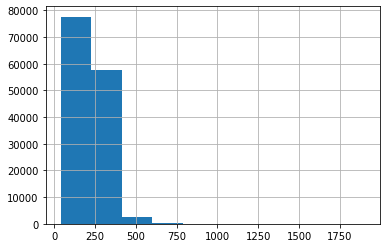

In [31]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [32]:
Train_resource.groupby('domain')['label']\
              .value_counts()

domain                             label   
ACEInhibitors.csv                  negative     2041
                                   positive      166
ADHD.csv                           negative      701
                                   positive       80
Antihistamines.csv                 negative      190
                                   positive       87
Appenzeller-Herzog_2020.csv        negative     2182
                                   positive      161
AtypicalAntipsychotics.csv         negative      670
                                   positive      329
BPA.csv                            negative     6980
                                   positive      101
Bannach-Brown_2019.csv             negative     1347
                                   positive      251
BetaBlockers.csv                   negative     1552
                                   positive      267
CalciumChannelBlockers.csv         negative      824
                                   positive      246
Es

#### Test Resource

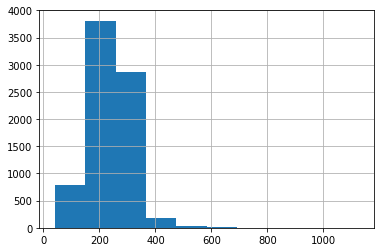

In [33]:
Test_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [34]:
Test_resource.groupby('domain')['label']\
              .value_counts()

domain                                label   
Distal_radius_fractures_approach.csv  negative     170
                                      positive      10
Hallux_valgus_prognostic.csv          negative     595
                                      positive      19
Head_and_neck_cancer_imaging.csv      negative      38
                                      positive      18
Obstetric_emergency_training.csv      negative     152
                                      positive      18
Pregnancy_medication.csv              negative     337
                                      positive      40
SR11_Li.csv                           negative     200
                                      positive       9
SR12_Cavender.csv                     negative     400
                                      positive      14
SR13_Chatterjee.csv                   negative     400
                                      positive      18
SR14_Funakoshi.csv                    negative    1000
                  

#### Validation Resource

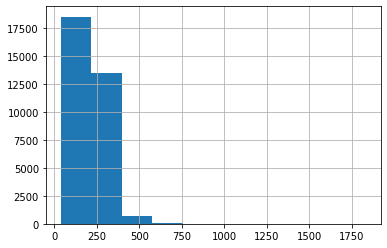

In [35]:
Valid_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [36]:
Valid_resource.groupby('domain')['label']\
              .value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


## 📚 Meta learning phase

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ANTIGA CONFIGURAÇAO DO ARTIGO
# {
#   "inner_print": 2,
#   "bert_layers": 4,    ##############
#   "max_seq_length": 512,
#   "meta_epoch": 20,    ############
#   "k_spt": 8,  # *
#   "k_qry": 8,
#   "outer_batch_size": 5,
#   "inner_batch_size": 4,
#   "outer_update_lr": 5e-05,
#   "inner_update_lr": 5e-05, ########
#   "inner_update_step": 4,  ##############
#   "inner_update_step_eval": 4,
#   "num_task_train": 20,
#   "pos_weight": 1.5,
#   "tresh": 0.9,
#   "model": "allenai/scibert_scivocab_uncased" ########
# }


# Meta-Training informations 
Info = {
    "device": device,
    "inner_print": 2, 
    "bert_layers": 4,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":10, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-3, # Learning rate of task optimizer
    "inner_update_lr" : 5e-3, # Learning rate of classification optimizer
    "inner_update_step" : 6 , #  loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 20, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

initializer_model.MODEL_NAME

# SLR classifier model
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                      #  model = initializer_model.model.bert,
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'
                       arch = 'mpnet'
                       )

# initializer_model.model.bert.encoder.layer[0].output.LayerNorm

# Trainable parammeters
print('trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in model.parameters()))

# Train the model
meta_train(data = Train_resource,
          model = model,
          Info = Info,
          print_epoch =True,
          size_layer=Info["bert_layers"],
          # Test_resource=Test_resource,
          treat_text_fun=treat_text_fun)

trainable params: 156306
Total params: 52349202


Meta epoch :   0%|                                       | 0/10 [00:00<?, ?it/s]


-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Transgenerational.csv ----
Inner Loss:  1.0688477456569672
Inner Loss:  0.32322506606578827
Inner Loss:  0.34265222400426865
----Task 1 : AtypicalAntipsychotics.csv ----
Inner Loss:  0.2127336747944355
Inner Loss:  0.040275271981954575
Inner Loss:  0.14890535967424512
----Task 2 : Neuropain.csv ----
Inner Loss:  1.1493249237537384
Inner Loss:  0.3461877480149269
Inner Loss:  0.17427720502018929
----Task 3 : Leafy_Greens.csv ----
Inner Loss:  1.1826276564970613
Inner Loss:  0.39830030128359795
Inner Loss:  0.785540260374546
----Task 4 : BPA.csv ----
Inner Loss:  1.0422308333218098
Inner Loss:  0.6764011569321156
Inner Loss:  0.7527194805443287


f1: 0.7013526797294617
recall: 0.925
Step: 0 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : van_de_Schoot_2017.csv ----
Inner Loss:  1.0633125379681587
Inner Loss:  0.745764933526516
Inner Loss:  0.46477314457297325
---

Meta epoch :  10%|███                            | 1/10 [00:56<08:29, 56.63s/it]

Step: 3 	training Acc: 0.525

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : ProtonPumpInhibitors.csv ----
Inner Loss:  0.8885021805763245
Inner Loss:  0.672150582075119
Inner Loss:  0.47347717732191086
----Task 1 : BPA.csv ----
Inner Loss:  0.42571762949228287
Inner Loss:  0.1509959027171135
Inner Loss:  0.42506833048537374
----Task 2 : Kwok_2020.csv ----
Inner Loss:  0.743638813495636
Inner Loss:  0.3637399598956108
Inner Loss:  0.33079221844673157
----Task 3 : van_Dis_2020.csv ----
Inner Loss:  1.2775171399116516
Inner Loss:  0.4708670303225517
Inner Loss:  0.32030468061566353
----Task 4 : Appenzeller-Herzog_2020.csv ----
Inner Loss:  0.8861948847770691
Inner Loss:  0.40179990231990814
Inner Loss:  0.6683720592409372


f1: 0.6838915705680847
recall: 0.95
Step: 0 	training Acc: 0.5625

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : Post_intensive_care_treatment.csv ----
Inner Loss:  0.7534868009388447
Inner Loss:  0.78172511

Meta epoch :  20%|██████▏                        | 2/10 [01:44<06:52, 51.57s/it]

Step: 3 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : UrinaryIncontinence.csv ----
Inner Loss:  0.3008635975420475
Inner Loss:  0.8235084973275661
Inner Loss:  0.12842167913913727
----Task 1 : Wahono_2015.csv ----
Inner Loss:  0.4935932084918022
Inner Loss:  0.904720913618803
Inner Loss:  0.08833592850714922
----Task 2 : Statins.csv ----
Inner Loss:  0.5831349566578865
Inner Loss:  0.3163474053144455
Inner Loss:  0.2525005517527461
----Task 3 : cereals.csv ----
Inner Loss:  0.846443384885788
Inner Loss:  0.9236807078123093
Inner Loss:  0.3419260047376156
----Task 4 : BetaBlockers.csv ----
Inner Loss:  1.2429516017436981
Inner Loss:  0.49466104060411453
Inner Loss:  0.3487788401544094


f1: 0.700000011920929
recall: 0.95
Step: 0 	training Acc: 0.5875

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : BPA.csv ----
Inner Loss:  0.36663421243429184
Inner Loss:  0.21993841975927353
Inner Loss:  0.1894767647609114

Meta epoch :  30%|█████████▎                     | 3/10 [02:32<05:50, 50.03s/it]

Step: 3 	training Acc: 0.575

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : BetaBlockers.csv ----
Inner Loss:  0.5893109440803528
Inner Loss:  0.5447736382484436
Inner Loss:  0.1433148756623268
----Task 1 : Kwok_2020.csv ----
Inner Loss:  0.4583015441894531
Inner Loss:  0.7071934677660465
Inner Loss:  0.40032984875142574
----Task 2 : Transgenerational.csv ----
Inner Loss:  0.18988693691790104
Inner Loss:  0.23026521131396294
Inner Loss:  0.040222256910055876
----Task 3 : Post_intensive_care_treatment.csv ----
Inner Loss:  1.211166113615036
Inner Loss:  0.9181715548038483
Inner Loss:  0.4315464496612549
----Task 4 : AtypicalAntipsychotics.csv ----
Inner Loss:  0.626998221501708
Inner Loss:  0.30009667202830315
Inner Loss:  0.22903328202664852


f1: 0.6664031863212585
recall: 0.975
Step: 0 	training Acc: 0.5125

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : van_Dis_2020.csv ----
Inner Loss:  0.4542410597205162
Inner Loss:  0.3

Meta epoch :  40%|████████████▍                  | 4/10 [03:21<04:55, 49.29s/it]

Step: 3 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : UrinaryIncontinence.csv ----
Inner Loss:  0.6361363288015127
Inner Loss:  0.3572937175631523
Inner Loss:  0.0945707131177187
----Task 1 : Neuropain.csv ----
Inner Loss:  0.9506939649581909
Inner Loss:  0.8479962795972824
Inner Loss:  0.6076923757791519
----Task 2 : van_de_Schoot_2017.csv ----
Inner Loss:  0.7508038729429245
Inner Loss:  0.6038507521152496
Inner Loss:  0.23899488523602486
----Task 3 : ACEInhibitors.csv ----
Inner Loss:  0.22709457855671644
Inner Loss:  0.285569304600358
Inner Loss:  0.15925129409879446
----Task 4 : NSAIDS.csv ----
Inner Loss:  0.595071118324995
Inner Loss:  0.3506751246750355
Inner Loss:  0.30343248322606087


f1: 0.6993939518928528
recall: 0.95
Step: 0 	training Acc: 0.5875

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : ProtonPumpInhibitors.csv ----
Inner Loss:  0.38684089481830597
Inner Loss:  0.21811905410140753
Inn

Meta epoch :  50%|███████████████▌               | 5/10 [04:08<04:03, 48.72s/it]

Step: 3 	training Acc: 0.575

-----------------Training Mode Meta_epoch: 5 -----------------

----Task 0 : BPA.csv ----
Inner Loss:  0.7262123860418797
Inner Loss:  0.5805108696222305
Inner Loss:  0.2849680185317993
----Task 1 : BetaBlockers.csv ----
Inner Loss:  0.8697491735219955
Inner Loss:  0.3340083621442318
Inner Loss:  0.1997293457388878
----Task 2 : Wahono_2015.csv ----
Inner Loss:  0.30699724424630404
Inner Loss:  0.5085520772263408
Inner Loss:  0.06906855292618275
----Task 3 : ADHD.csv ----
Inner Loss:  0.21826834976673126
Inner Loss:  0.1334229838103056
Inner Loss:  0.018946353113278747
----Task 4 : Nagtegaal_2019.csv ----
Inner Loss:  0.629629909992218
Inner Loss:  0.4362119063735008
Inner Loss:  0.6661934442818165


f1: 0.6840580224990844
recall: 0.975
Step: 0 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 5 -----------------

----Task 0 : CalciumChannelBlockers.csv ----
Inner Loss:  0.7351618148386478
Inner Loss:  0.8671597614884377
Inner Loss:  0.2991234

Meta epoch :  60%|██████████████████▌            | 6/10 [04:58<03:15, 48.95s/it]

Step: 3 	training Acc: 0.6

-----------------Training Mode Meta_epoch: 6 -----------------

----Task 0 : Leafy_Greens.csv ----
Inner Loss:  0.6700032502412796
Inner Loss:  0.46899788454174995
Inner Loss:  0.5391790755093098
----Task 1 : Kwok_2020.csv ----
Inner Loss:  0.3614647053182125
Inner Loss:  0.13848969526588917
Inner Loss:  0.291942797601223
----Task 2 : cereals_Future_set.csv ----
Inner Loss:  0.3285566777922213
Inner Loss:  0.2395090674981475
Inner Loss:  0.09936228534206748
----Task 3 : Post_intensive_care_treatment.csv ----
Inner Loss:  0.49714280664920807
Inner Loss:  0.2956914734095335
Inner Loss:  0.2404656382277608
----Task 4 : cereals.csv ----
Inner Loss:  0.34740184247493744
Inner Loss:  0.7883669510483742
Inner Loss:  0.26214045472443104


f1: 0.6903821229934692
recall: 1.0
Step: 0 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 6 -----------------

----Task 0 : Transgenerational.csv ----
Inner Loss:  0.20994911342859268
Inner Loss:  0.164298595860600

Meta epoch :  70%|█████████████████████▋         | 7/10 [05:46<02:26, 48.67s/it]

Step: 3 	training Acc: 0.5375

-----------------Training Mode Meta_epoch: 7 -----------------

----Task 0 : Appenzeller-Herzog_2020.csv ----
Inner Loss:  0.8586881011724472
Inner Loss:  0.26505549252033234
Inner Loss:  0.45671431347727776
----Task 1 : Kwok_2020.csv ----
Inner Loss:  0.7619274854660034
Inner Loss:  0.2830352820456028
Inner Loss:  0.19186994805932045
----Task 2 : Hall_2012.csv ----
Inner Loss:  0.16944033093750477
Inner Loss:  0.29337590374052525
Inner Loss:  0.01992011326365173
----Task 3 : Transgenerational.csv ----
Inner Loss:  0.648728284984827
Inner Loss:  0.31059854477643967
Inner Loss:  0.0997027400881052
----Task 4 : Kwok_2020.csv ----
Inner Loss:  0.7093139290809631
Inner Loss:  0.5484254658222198
Inner Loss:  0.45599455386400223


f1: 0.6991304636001587
recall: 1.0
Step: 0 	training Acc: 0.5625

-----------------Training Mode Meta_epoch: 7 -----------------

----Task 0 : Transgenerational.csv ----
Inner Loss:  0.9154433012008667
Inner Loss:  0.6469810493290424


Meta epoch :  80%|████████████████████████▊      | 8/10 [06:34<01:36, 48.43s/it]

Step: 3 	training Acc: 0.5375

-----------------Training Mode Meta_epoch: 8 -----------------

----Task 0 : Leafy_Greens.csv ----
Inner Loss:  0.45524947717785835
Inner Loss:  0.7103824149817228
Inner Loss:  0.5015008114278316
----Task 1 : van_Dis_2020.csv ----
Inner Loss:  0.32788173109292984
Inner Loss:  0.38900233060121536
Inner Loss:  0.6973459087312222
----Task 2 : Triptans.csv ----
Inner Loss:  0.4274125564843416
Inner Loss:  0.08071695640683174
Inner Loss:  0.10800427896901965
----Task 3 : Hall_2012.csv ----
Inner Loss:  0.13953325431793928
Inner Loss:  0.3720100149512291
Inner Loss:  0.02955081034451723
----Task 4 : BetaBlockers.csv ----
Inner Loss:  0.5510665327310562
Inner Loss:  0.20986680686473846
Inner Loss:  0.12943046540021896


f1: 0.6608339309692383
recall: 0.9
Step: 0 	training Acc: 0.55

-----------------Training Mode Meta_epoch: 8 -----------------

----Task 0 : AtypicalAntipsychotics.csv ----
Inner Loss:  0.8745314329862595
Inner Loss:  0.44499562308192253
Inner Lo

Meta epoch :  90%|███████████████████████████▉   | 9/10 [07:22<00:48, 48.35s/it]

Step: 3 	training Acc: 0.5125

-----------------Training Mode Meta_epoch: 9 -----------------

----Task 0 : UrinaryIncontinence.csv ----
Inner Loss:  0.870863676071167
Inner Loss:  1.1139471009373665
Inner Loss:  0.7248779386281967
----Task 1 : Leafy_Greens.csv ----
Inner Loss:  0.5851661078631878
Inner Loss:  0.7300653457641602
Inner Loss:  0.39796312898397446
----Task 2 : NSAIDS.csv ----
Inner Loss:  0.6706935167312622
Inner Loss:  0.5149492844939232
Inner Loss:  0.5870890282094479
----Task 3 : Hall_2012.csv ----
Inner Loss:  0.31964023038744926
Inner Loss:  0.6474966630339622
Inner Loss:  0.19128753244876862
----Task 4 : ProtonPumpInhibitors.csv ----
Inner Loss:  0.7028856426477432
Inner Loss:  0.4994460716843605
Inner Loss:  0.38592250272631645


f1: 0.6724637985229492
recall: 1.0
Step: 0 	training Acc: 0.5125

-----------------Training Mode Meta_epoch: 9 -----------------

----Task 0 : SR10_Kourbeti.csv ----
Inner Loss:  0.22079802118241787
Inner Loss:  0.17156830057501793
Inner L

Meta epoch : 100%|██████████████████████████████| 10/10 [08:11<00:00, 49.13s/it]

Step: 3 	training Acc: 0.5625


## 📕 Model evaluation

In [38]:
Valid_resource.groupby('domain')['label'].value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


### Task diagnosis

In [2]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(Valid_resource,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Opiods.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(Valid_resource[Valid_resource['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


ModuleNotFoundError: ignored

#### Untrained model

acc: 0.5


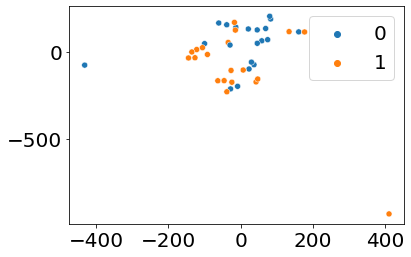

In [59]:
#@title Untrainded model
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(features[0].to('cpu'))


# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()
del inner_optimizer, model_to_finetunning, q_input_ids, q_attention_mask, q_token_type_ids, q_label_id, query_batch
torch.cuda.empty_cache()


#### Trained model

In [1]:
#@title Trained model

model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()

NameError: ignored

## 📕 Domain learning phase
 
Evaluates the model in domain learner phase on the validation resource

In [56]:
Valid_resource.groupby('domain')['label'].value_counts()

domain                                        label   
Bos_2018.csv                                  negative    5593
                                              positive      11
Distal_radius_fractures_closed_reduction.csv  negative     244
                                              positive       6
Fluoride.csv                                  negative    3813
                                              positive      49
Head_and_neck_cancer_bone.csv                 negative     266
                                              positive      32
Kitchenham_2010.csv                           negative    1631
                                              positive      45
Leafy_Greens_Future_set.csv                   positive      62
                                              negative      32
Opiods.csv                                    negative    1675
                                              positive      41
PFOS-PFOA.csv                                 negative    5831


### Tasks diagnosis

It's possible to access some of the data from the testing dataset after pressing "Train" in the object stantiated by the `diagnosis`, such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

*After press Train Button to perform a domain learning, it's possible evaluate the text used to predict a label by the model in the [Domain Text Avaliation of Positives examples](#another_cell)

In [60]:
config = Info.copy()

config['tresh'] = 0.9
# config["inner_update_step_eval"] = 5
config["inner_print"] = 1
config['inner_update_step'] = 10

pprint(config)

{'bert_layers': 4,
 'device': device(type='cuda'),
 'inner_batch_size': 4,
 'inner_print': 1,
 'inner_update_lr': 0.005,
 'inner_update_step': 10,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 10,
 'num_task_train': 20,
 'outer_batch_size': 5,
 'outer_update_lr': 0.005,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='sentence-transformers/paraphrase-mpnet-base-v2', vocab_size=30527, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '[UNK]', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}),
 'tresh': 0.9}


Opiods.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    1665
positive      31
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.1517, R: 0.9677
ASSWSS@95:0.1545
Acc.: 0.2011
F1-score: 0.0424
Treshold to wss95: 0.1289999932050705

Confusion matrix:
       Predict      
             0     1
Real 0     311  1354
     1       1    30

---Metrics with threshold: 0.9 ----

WSS@R:0.4076, R: 0.7419
AWSS@R:0.4152
Acc.: 0.6745
F1-score: 0.0769

Confusion matrix:
       Predict     
             0    1
Real 0    1121  544
     1       8   23


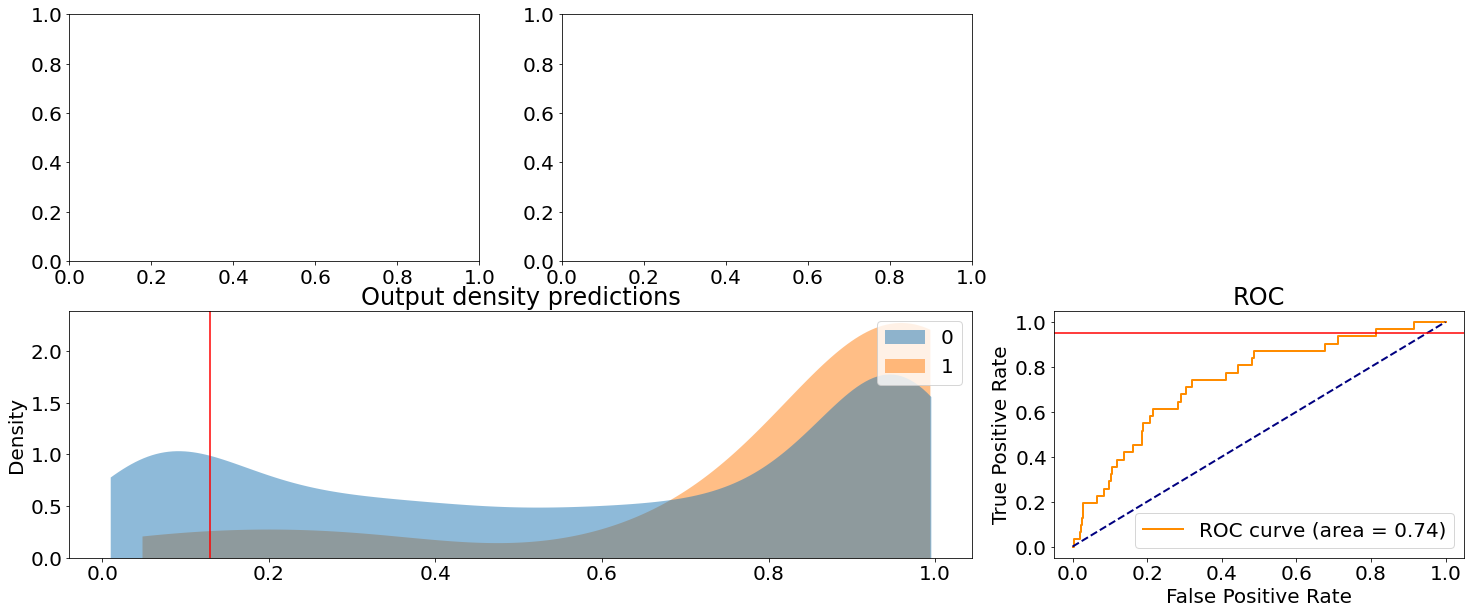

In [58]:
#@title Evaluating validation dataset (without meta-learning)
batch_size_test =   100 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()

modelx = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                      #  model = initializer_model.model.bert,
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'
                       arch = 'mpnet'
                       )

diagnosis5050 = diagnosis(names,
                          Valid_resource,
                          batch_size_test,
                          modelx,
                          config,
                          treat_text_fun=treat_text_fun,
                          start=0)
diagnosis5050()

Opiods.csv
-------Train data-------
negative    10
positive    10
Name: label, dtype: int64
-------Test data-------
negative    1665
positive      31
Name: label, dtype: int64


Button(description='Next', style=ButtonStyle())

WSS@95:0.2673, R: 0.9677
ASSWSS@95:0.2722
Acc.: 0.3166
F1-score: 0.0492
Treshold to wss95: 0.1981000006198883

Confusion matrix:
       Predict      
             0     1
Real 0     507  1158
     1       1    30

---Metrics with threshold: 0.9 ----

WSS@R:0.48, R: 0.871
AWSS@R:0.489
Acc.: 0.6226
F1-score: 0.0778

Confusion matrix:
       Predict     
             0    1
Real 0    1029  636
     1       4   27


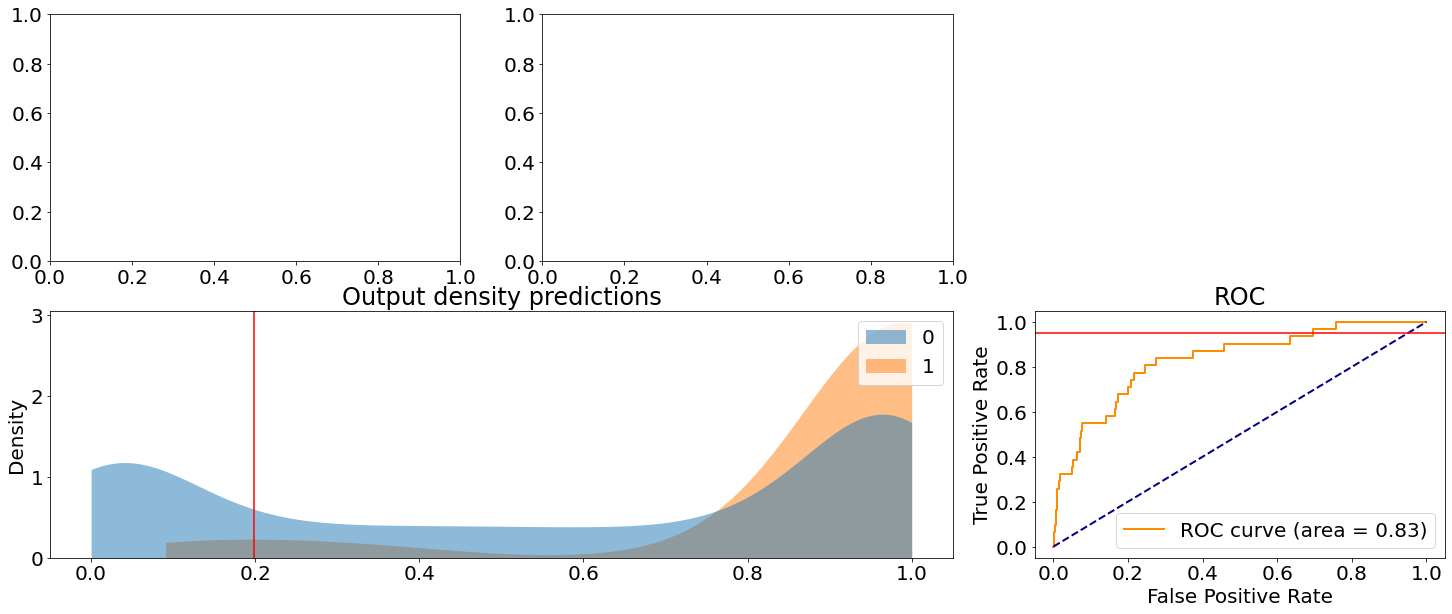

In [61]:
#@title Evaluating validation dataset
batch_size_test =   100 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()


diagnosis5050 = diagnosis(names,
                          Valid_resource,
                          batch_size_test,
                          model,
                          config,
                          treat_text_fun=treat_text_fun,
                          start=0)
diagnosis5050()

### Domain Text Avaliation of Positives examples <a id='Text_avaliation'></a>

In [46]:
data_test = diagnosis5050.data_test
logits = diagnosis5050.logits

# random choice a positive example
indx= data_test[data_test['label'] == 'positive'].index
indx= np.random.choice(indx)


# print the example
pprint(data_test.iloc[indx])

# Prediction by the model
print("Predicted:",torch.sigmoid(logits[indx]).item() )

# Text of the example
print('Treated Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

# Text of the example
print('Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

index                                                  1267
text      Gene Expression Profiling in Wild-Type and PPA...
domain                                        PFOS-PFOA.csv
label                                              positive
Name: 1261, dtype: object
Predicted: 0.5504085421562195
Treated Text:
('gene expression profiling in wild-type and pparalpha-null mice exposed to '
 'perfluorooctane sulfonate reveals pparalpha-independent '
 'effects.perfluorooctane sulfonate , and possibly ppargamma and/or '
 'pparbeta/delta. unique treatment-related effects were also found in null '
 'mice including altered expression of genes associated with ribosome '
 'biogenesis, oxidative phosphorylation, and cholesterol biosynthesis. of '
 'interest was up-regulation of cyp7a1, a gene which is under the control of '
 'various transcription regulators. hence, in addition to its ability to '
 'modestly activate pparalpha, pfos induces a variety of pparalpha-independent '
 'effects as well.')
T

## Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

base_path = '5050split'
path_save = "./"+"Models/"+base_path+"/"


# Creating directory
Path(path_save).mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
Path(f"{path_save}/{check}").mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'{path_save}/{check}/model.pt'
meta_info_path = f'{path_save}/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model.state_dict(), model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

## Load model

In [ ]:
# Downloading entire model
# Config the model that was saved
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )

model.state_dict(torch.load(model_path))
model

## 📗 Computing simulation attemps (50-50)


5 attemps in the domain learner phase with the validation resource is computed to evaluate the performance of the model.

In [ ]:
names_to_valid = Valid_resource['domain'].unique()

In [ ]:
# names that will be validated
print(names_to_valid)

['PFOS-PFOA.csv' 'Vascular_access.csv'
 'Distal_radius_fractures_closed_reduction.csv'
 'Shoulder_replacement_surgery.csv' 'Head_and_neck_cancer_bone.csv'
 'Total_knee_replacement.csv' 'Shoulder_replacement_diagnostic.csv'
 'Leafy_Greens_Future_set.csv' 'Radjenovic_2013.csv' 'Kitchenham_2010.csv'
 'Wolters_2018.csv' 'Bos_2018.csv' 'Opiods.csv'
 'SkeletalMuscleRelaxants.csv' 'Fluoride.csv']


In [ ]:
info_load[  info_load['names'].isin(names_to_valid)]

,size,pos,neg,names,paths
15,728,19,709,Vascular_access.csv,SLR_data/Medical Guidelines Dutch Association ...
18,180,4,176,Distal_radius_fractures_closed_reduction.csv,SLR_data/Medical Guidelines Dutch Association ...
20,376,6,370,Shoulder_replacement_surgery.csv,SLR_data/Medical Guidelines Dutch Association ...
23,228,32,196,Head_and_neck_cancer_bone.csv,SLR_data/Medical Guidelines Dutch Association ...
26,311,25,286,Total_knee_replacement.csv,SLR_data/Medical Guidelines Dutch Association ...
27,329,3,326,Shoulder_replacement_diagnostic.csv,SLR_data/Medical Guidelines Dutch Association ...
28,95,62,33,Leafy_Greens_Future_set.csv,SLR_data/Automatic classification of literatur...
32,6000,48,5952,Radjenovic_2013.csv,SLR_data/asreview/Radjenovic_2013.csv
34,1700,45,1655,Kitchenham_2010.csv,SLR_data/asreview/Kitchenham_2010.csv
37,4212,19,4193,Wolters_2018.csv,SLR_data/asreview/Wolters_2018.csv


In [ ]:
pprint(Info)

{'bert_layers': 2,
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-05,
 'inner_update_step': 4,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 5,
 'num_task_train': 2,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}


In [ ]:
# import wandb
# wandb.login()

In [ ]:
base_path = '5050split'
path_save = "./"+"Results/"+base_path+"/"
Info['tresh'] = 0.9
config = Info.copy()
config.pop('tokenizer')


# wandb.init(project= 'Meta-Learning-SLRC',
#            config = config,
#            name= initializer_model.MODEL_NAME,
#            entity="lamfo-mcti")

PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = names_to_valid[4:6],  ## Coloque aqui qual que vai ser 
                    path_save = path_save, 
                    model=model, epochs=[Info['inner_update_step']], Info=Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 100)

# wandb.finish()

# 🛸 Ablation

In [ ]:
ablation = {
    # Aplicar no aprender a aprender
    'bert_layers': [2,4,6,12],
    # Aplicar no aprender a tarefa
    'epochs': [2, 4, 8, 16],
    'k_spt': [2,4, 8, 16],  # Tamanho do banco de treino (N-exemplos por classe)

    # Bancos de dados
    'names_ablation' : [
        'PFOS-PFOA.csv',            #
        'Fluoride.csv',             #
        'Kitchenham_2010.csv',      #
        'Opiods.csv']               #
}

# 
Info['tresh'] = 0.9

## Ablation finetunning (apreder a tarefa)

### Epochs

Modelo Treinado com Meta-Learning


In [ ]:
path_save = './Results/Ablation/Epochs/meta_model/'
# model
pipeline_simulation(Valid_resource = Valid_resource,
                    # names_to_valid = ablation['names_ablation'], 
                    names_to_valid = [ ablation['names_ablation'][0] ], 
                    path_save = path_save, 
                    model=model, 
                    epochs=ablation['epochs'], Info=Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5,
                    batch_test= 100,
                    tsne = False, make_plot = False)

Modelo Treinado sem Meta-Learning, apenas adicionando os adapters, sem passar pela fazer de meta-learning

In [ ]:
path_save = './Results/Ablation/Epochs/standart_model/'

standart_model = SLR_Classifier(
    bert_layers = range(Info["bert_layers"]),
    freeze_bert = True,
    model = initializer_model.model.bert,
    # model = initializer_model.model.mpnet,
    # drop=0.2,
    arch = 'bert',
    # arch = 'mpnet'
    meta_learner = False)

# model
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=standart_model,
                    epochs=ablation['epochs'], Info=Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 100,
                    tsne = False, make_plot = False)

### DataTrain size

Modelo Treinado com Meta-Learning


In [ ]:
config = Info.copy()
for data_size in ablation['k_spt']:
  config['k_spt'] = data_size

  path_save = './Results/Ablation/DataSize/meta_model/'
  # model
  pipeline_simulation(Valid_resource = Valid_resource,
                      names_to_valid = ablation['names_ablation'], 
                      path_save = path_save, 
                      model=model, 
                      epochs=[config['inner_update_step']], Info=config,
                      treat_text_fun = treat_text_fun,
                      initializer_model = initializer_model,
                      n_attempt=5, batch_test= 100,
                      tsne = False, make_plot = False)

Modelo Treinado sem Meta-Learning, apenas adicionando os adapters, sem passar pela fazer de meta-learning

In [ ]:
config = Info.copy()
for data_size in ablation['k_spt']:
  config['k_spt'] = data_size

  path_save = './Results/Ablation/DataSize/standart_model/'

  standart_model = SLR_Classifier(
      bert_layers = range(Info["bert_layers"]),
      freeze_bert = True,
      model = initializer_model.model.bert,
      # model = initializer_model.model.mpnet,
      # drop=0.2,
      arch = 'bert',
      # arch = 'mpnet'
      meta_learner = False)



  # model
  pipeline_simulation(Valid_resource = Valid_resource,
                      names_to_valid = ablation['names_ablation'], 
                      path_save = path_save, 
                      model=standart_model,
                      epochs=[config['inner_update_step']], Info=config,
                      treat_text_fun = treat_text_fun,
                      initializer_model = initializer_model,
                      n_attempt=5, batch_test= 100,
                      tsne = False, make_plot = False)

## Ablation (size model)

Treinar o modelo na faze de meta learning e testar com as configurações padrões achadas nos experimento 50-50 (configurações do `Info`)

In [ ]:
pprint(Info)

{'bert_layers': 2,
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-05,
 'inner_update_step': 4,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 5,
 'num_task_train': 2,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'tresh': 0.9}


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tentativa_do_ablation = 0 ## TROCAR AQUI QUAL VAI SER A QUANTIDADE DE LAYERS conforme em ablation = {...}
Info["bert_layers"] = ablation['bert_layers'][tentativa_do_ablation]


# SLR classifier model
model_ablation = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,      # Trocar se é o mpnet
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'                              # Trocar se é o mpnet
                      #  arch = 'mpnet'
                       )


# Trainable parammeters
print('trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in model.parameters()))

# Train the model
meta_train(data = Train_resource,
          model = model_ablation,
          device = device,
          Info = Info,
          print_epoch =False,
          size_layer=Info["bert_layers"],
          # Test_resource=Test_resource,    # Não precisa testar
          treat_text_fun=treat_text_fun)

trainable params: 156306
Total params: 39196050


Meta epoch :  20%|██████▍                         | 1/5 [00:01<00:07,  1.78s/it]



f1: 0.7830882668495178
recall: 0.8125


Meta epoch :  40%|████████████▊                   | 2/5 [00:03<00:05,  1.74s/it]



f1: 0.27272728085517883
recall: 0.1875


Meta epoch :  60%|███████████████████▏            | 3/5 [00:05<00:03,  1.69s/it]



f1: 0.48461539298295975
recall: 0.375


Meta epoch :  80%|█████████████████████████▌      | 4/5 [00:06<00:01,  1.69s/it]



f1: 0.5432692319154739
recall: 0.5


Meta epoch : 100%|████████████████████████████████| 5/5 [00:08<00:00,  1.70s/it]



f1: 0.2371794953942299
recall: 0.1875


Modelo Treinado com Meta-Learning


In [ ]:
path_save = './Results/Ablation/Size/meta_model/'
# model
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=model_ablation, 
                    epochs= [Info['inner_update_step']], Info=Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 100,
                    tsne = False, make_plot = False)

Modelo Treinado sem Meta-Learning, apenas adicionando os adapters, sem passar pela fazer de meta-learning

In [ ]:
path_save = './Results/Ablation/Size/standart_model/'

standart_model = SLR_Classifier(
    bert_layers = range(Info["bert_layers"]),
    freeze_bert = True,
    model = initializer_model.model.bert,
    # model = initializer_model.model.mpnet,
    # drop=0.2,
    arch = 'bert',
    # arch = 'mpnet'
    meta_learner = False)

# model
pipeline_simulation(Valid_resource = Valid_resource,
                    names_to_valid = ablation['names_ablation'], 
                    path_save = path_save, 
                    model=standart_model,
                    epochs=[Info['inner_update_step']], Info=Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 100,
                    tsne = False, make_plot = False)

# 🎁 Benchmark simulation (Benchmark)

This section explore the methodology of train the ML-SLRC with the remain dataset that don't correspond the Benchmarks datasets, [SWIFT](https://pubmed.ncbi.nlm.nih.gov/27216467/) and [cohen Drugs Review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1447545/) to peform a comparison of WSS@95 in the ([Kusa at al., 2022](https://arxiv.org/abs/2201.07534)).


### 🎫 Data


#### Directory creation

In [ ]:
import glob
import os

path = 'SLR_data'

cohen_paths = glob.glob(f"{path}/**/cohen/*.csv", recursive=True)
SWIFT_paths = glob.glob(f"{path}/**/SWIFT systematic review data/*.csv", recursive=True)

cohen_names = [os.path.basename(p) for p in cohen_paths]
SWIFT_names = [os.path.basename(p) for p in SWIFT_paths]

base_path = 'Comparison'

#### Data split

In [ ]:
from itertools import chain

All_data = load_data(
    info_load
)

All_data = All_data.dropna().reset_index().drop("index", axis=1)

comparison_names = list(chain.from_iterable([cohen_names, SWIFT_names]))

cohen_data = All_data[All_data['domain'].isin(cohen_names)]
cohen_data =  cohen_data.reset_index().drop("index", axis=1)

SWIFT_data = All_data[All_data['domain'].isin(SWIFT_names)]
SWIFT_data =  SWIFT_data.reset_index().drop("index", axis=1)

Train_resource = All_data[~All_data['domain'].isin(comparison_names)]
Train_resource =  Train_resource.reset_index().drop("index", axis=1)

In [ ]:
# Selecting data with at least 40 words separated by spaces
crit = Train_resource["text"].apply(lambda x: len(x.split(" "))) >= 40
Train_resource = Train_resource[crit].reset_index().drop("index", axis=1)

### 🔎🎫Exploratory Data Analysis

Histograms of number of words separated by " " and count of positive and negative examples of each dataset of the resource

#### Train Resource



In [ ]:
Train_resource["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
Train_resource.groupby('domain')['label']\
              .value_counts()

#### cohen Dataset

In [ ]:
cohen_data["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
cohen_data.groupby('domain')['label']\
              .value_counts()

#### SWIFT Dataset

In [ ]:
SWIFT_data["text"].apply(lambda x: len(x.split(" "))).hist()
plt.show()

In [ ]:
SWIFT_data.groupby('domain')['label']\
              .value_counts()

## 📚 Meta learning phase

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# ANTIGA CONFIGURAÇAO DO ARTIGO
# {
#   "inner_print": 2,
#   "bert_layers": 4,    ##############
#   "max_seq_length": 512,
#   "meta_epoch": 20,    ############
#   "k_spt": 8,  # *
#   "k_qry": 8,
#   "outer_batch_size": 5,
#   "inner_batch_size": 4,
#   "outer_update_lr": 5e-05,
#   "inner_update_lr": 5e-05, ########
#   "inner_update_step": 4,  ##############
#   "inner_update_step_eval": 4,
#   "num_task_train": 20,
#   "pos_weight": 1.5,
#   "tresh": 0.9,
#   "model": "allenai/scibert_scivocab_uncased" ########
# }


# Meta-Training informations 
Info = {
    "inner_print": 2, 
    "bert_layers": 2,
    "tokenizer": initializer_model.tokenizer,
    "max_seq_length": 512,
    "meta_epoch":5, # Outer loop epochs
    "k_spt":8, # Support (training) examples per class, binary case
    "k_qry":8, # Query (testing) examples per class, binary case
    "outer_batch_size": 5, # Size of batch of tasks
    "inner_batch_size": 4, # Size of batch of classifications
    "outer_update_lr" : 5e-5, # Learning rate of task optimizer
    "inner_update_lr" : 5e-5, # Learning rate of classification optimizer
    "inner_update_step" : 4 , # Inner loop epochs (learn example task)
    "inner_update_step_eval": 4, # Validation inner loop epochs
    "num_task_train" : 2, # Number of training tasks
    # "num_task_test" : 5 # Number of testing tasks
    "pos_weight" : 1.5 # p > 1 increases recall, p < 1 increases precision, applied in loss function
}

initializer_model.MODEL_NAME

# SLR classifier model
model = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                       model = initializer_model.model.bert,
                      #  model = initializer_model.model.mpnet,
                       drop=0.2,
                       arch = 'bert'
                      #  arch = 'mpnet'
                       )

# initializer_model.model.bert.encoder.layer[0].output.LayerNorm

# Trainable parammeters
print('trainable params:', sum(p.numel() for p in model.parameters() if p.requires_grad))
print('Total params:', sum(p.numel() for p in model.parameters()))

# Train the model
meta_train(data = Train_resource,
          model = model,
          device = device,
          Info = Info,
          print_epoch =True,
          size_layer=Info["bert_layers"],
          Test_resource=Test_resource,
          treat_text_fun=treat_text_fun)

trainable params: 156306
Total params: 39196050


Meta epoch :   0%|                                        | 0/5 [00:00<?, ?it/s]


-----------------Training Mode Meta_epoch: 0 -----------------

----Task 0 : Leafy_Greens.csv ----
Inner Loss:  1.1146841049194336
Inner Loss:  1.0159186571836472
----Task 1 : Obstetric_emergency_training.csv ----
Inner Loss:  1.083197921514511
Inner Loss:  0.9974634051322937


f1: 0.6969697177410126
recall: 0.9375


Meta epoch :  20%|██████▍                         | 1/5 [00:03<00:13,  3.27s/it]

Step: 0 	training Acc: 0.59375

-----------------Training Mode Meta_epoch: 1 -----------------

----Task 0 : SR9_Douxfils.csv ----
Inner Loss:  1.2181954781214397
Inner Loss:  0.9862029552459717
----Task 1 : SR6_Wang.csv ----
Inner Loss:  1.070693850517273
Inner Loss:  1.124218612909317


f1: 0.9059829413890839
recall: 1.0


Meta epoch :  40%|████████████▊                   | 2/5 [00:06<00:09,  3.21s/it]

Step: 0 	training Acc: 0.8990384638309479

-----------------Training Mode Meta_epoch: 2 -----------------

----Task 0 : Obstetric_emergency_training.csv ----
Inner Loss:  1.1650463938713074
Inner Loss:  1.061424195766449
----Task 1 : Bannach-Brown_2019.csv ----
Inner Loss:  1.0902710855007172
Inner Loss:  1.0712418407201767


f1: 0.6339713037014008
recall: 0.8125


Meta epoch :  60%|███████████████████▏            | 3/5 [00:09<00:05,  2.97s/it]

Step: 0 	training Acc: 0.53125

-----------------Training Mode Meta_epoch: 3 -----------------

----Task 0 : SR7_Zhou.csv ----
Inner Loss:  1.2200406789779663
Inner Loss:  1.135865330696106
----Task 1 : Shoulderdystocia_recurrence.csv ----
Inner Loss:  1.1520845890045166
Inner Loss:  1.0620249509811401


f1: 0.7386363744735718
recall: 1.0
Step: 0 	training Acc: 0.6333333551883698

-----------------Testing Mode-----------------

----Task 0 : SR12_Cavender.csv ----
Inner Loss:  1.077071189880371
Inner Loss:  0.9526138603687286


f1: 1.0
recall: 1.0
----Task 0 : SR14_Funakoshi.csv ----
Inner Loss:  0.9225784540176392
Inner Loss:  0.8686007142066956


f1: 1.0
recall: 1.0
----Task 0 : SR7_Zhou.csv ----
Inner Loss:  1.046162337064743
Inner Loss:  0.9999887943267822


f1: 0.7272727489471436
recall: 1.0
----Task 0 : SR9_Douxfils.csv ----
Inner Loss:  1.0494270324707031
Inner Loss:  0.8750023444493612


f1: 1.0
recall: 1.0
----Task 0 : SR6_Wang.csv ----
Inner Loss:  0.9823261857032776
Inner Los

Meta epoch :  80%|█████████████████████████▌      | 4/5 [00:30<00:10, 10.11s/it]



f1: 0.75
recall: 1.0
Test acc: 0.7616571128368378

-----------------Training Mode Meta_epoch: 4 -----------------

----Task 0 : Shoulderdystocia_recurrence.csv ----
Inner Loss:  1.07697331905365
Inner Loss:  0.8520129919052124
----Task 1 : Head_and_neck_cancer_bone.csv ----
Inner Loss:  1.1540904939174652
Inner Loss:  1.0654930770397186


f1: 0.7228261232376099
recall: 1.0


Meta epoch : 100%|████████████████████████████████| 5/5 [00:35<00:00,  7.12s/it]

Step: 0 	training Acc: 0.581250011920929


## 📕 Model evaluation

In [ ]:
SWIFT_data.groupby('domain')['label'].value_counts()

### Task diagnosis

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

# Initializing model
model_to_finetunning = deepcopy(model)

# Creating validation tasks
valid = MetaTask(SWIFT_data,
                 num_task = 500,
                 k_support=10,
                 k_query=20,
                 tokenizer = Info['tokenizer'],
                 training=False)

# Diagnostic dataset
i = valid.task_names =='Neuropain.csv'

# Task index
idx = np.array(range(len(i)))[i].item()

# Support (train) e query (test) data
support = valid[idx][0]
query   = valid[idx][1]
name   = valid[idx][2]

print(name)
print(SWIFT_data[SWIFT_data['domain']== name]['label'].value_counts())
print("k_suport_examples:",len(support))
print("k_query_examples:",len(query))

# Support data loader
support_dataloader = DataLoader(support, sampler=RandomSampler(support),
                                batch_size=5)


#### Untrained model

In [ ]:
#@title Trained model padrão
model_to_finetunning.to(device)

# Inner Optimizer
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)


# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)

# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(features[0].to('cpu'))


# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id)
plt.show()
del inner_optimizer, model_to_finetunning, q_input_ids, q_attention_mask, q_token_type_ids, q_label_id, query_batch
torch.cuda.empty_cache()


#### Trained model

In [ ]:
#@title Trained model padrão

model_to_finetunning = deepcopy(model)
inner_optimizer = Adam(model_to_finetunning.parameters(), lr=5e-5)
model_to_finetunning.train()
model_to_finetunning.to(device)

# Inner loop training
for i in range(0,Info['inner_update_step']):
    all_loss = []

    # Inner training batch (support set)
    for inner_step, batch in enumerate(support_dataloader):
        
        batch = tuple(t.to("cuda") for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        # Feed Foward
        loss, _, _ = model_to_finetunning(input_ids, attention_mask, token_type_ids=token_type_ids, labels = label_id)
                      
        loss.backward()
        inner_optimizer.step()
        inner_optimizer.zero_grad()
        
        all_loss.append(loss.item())
    
    if i % Info["inner_print"] == 0:
        print("Inner Loss: ", np.mean(all_loss))

# Predicting
model_to_finetunning.eval()
with torch.no_grad():
    query_dataloader = DataLoader(query, sampler=None, batch_size=len(query))
    query_batch = next(iter(query_dataloader))
    query_batch = tuple(t.to(device) for t in query_batch)
    q_input_ids, q_attention_mask, q_token_type_ids, q_label_id = query_batch
    
    # Predictions
    _, features, predictions = model_to_finetunning(q_input_ids, q_attention_mask, q_token_type_ids, labels = q_label_id)

    predictions = predictions.detach().cpu().squeeze()
    q_label_id = q_label_id.detach().cpu()

    acc = fn.accuracy(predictions, q_label_id).item()
    print("acc:",acc)



model_to_finetunning.to(torch.device('cpu'))
del  inner_optimizer, model_to_finetunning
torch.cuda.empty_cache()


# TSNE Dimensionality reduction
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(features[0].to('cpu'))

# Plot
sns.scatterplot(x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue=q_label_id,
                alpha=torch.sigmoid(features[1]).to('cpu').view(-1))
plt.show()
del inner_optimizer, model_to_finetunning, q_input_ids, q_attention_mask, q_token_type_ids, q_label_id, query_batch
torch.cuda.empty_cache()

## 📕 Domain learning phase on SWIFT datasets

In [ ]:
SWIFT_data.groupby('domain')['label'].value_counts()

### 🔎 Diagnosis

In [ ]:
config = Info.copy()

config['tresh'] = 0.9
config["inner_update_step_eval"] = 5
config["inner_print"] = 1
config['inner_update_step'] = 10

pprint(config)

It's possible to access some of the data from the testing dataset after pressing "Train" in the object stantiated by the `diagnosis`, such as:

+ `logits`: logits from classifier stage, no activation

+ `X_embedded`: 2-dimensional values from dimensionality reduction of the latent space

+ `features`: Latent space values  (feature_map layer output)

+ `labels`: True values

+ `data_train`: Training data (Not the same order given to the model on training)

+ `data_test`: Testing data

+ `batch_size_test`: Batch size from the testing dataset, so that prediction time can be reduced

*After press Train Button to perform a domain learning, it's possible evaluate the text used to predict a label by the model in the [Domain Text Avaliation of Positives examples](#Text_avaliation_2)

In [ ]:
#@title Evaluating validation dataset (without meta-learning)
batch_size_test =   100 #@param {type:"number"}
# Task names
names = Valid_resource['domain'].unique()

modelx = SLR_Classifier(bert_layers = range(Info["bert_layers"]),
                       freeze_bert = True,
                      #  model = initializer_model.model.bert,
                       model = initializer_model.model.mpnet,
                       drop=0.2,
                      #  arch = 'bert'
                       arch = 'mpnet'
                       )

diagnosis_comp = diagnosis(names,
                           SWIFT_data,
                           batch_size_test,
                           modelx,
                           config,
                           treat_text_fun=treat_text_fun,
                           start=0)
diagnosis_comp()

Button(description='Next', style=ButtonStyle())

In [ ]:
#@title Evaluating validation dataset
batch_size_test =   20 #@param {type:"number"}
# Task names
names = SWIFT_data['domain'].unique()

diagnosis_comp = diagnosis(names,
                           SWIFT_data,
                           batch_size_test,
                           model,
                           config,
                           treat_text_fun=treat_text_fun,
                           start=0)
diagnosis_comp()

### 🔎 Text Avaliation of Positives examples <a id='Text_avaliation_2'></a>

In [ ]:
data_test = diagnosis_comp.data_test
logits = diagnosis_comp.logits

# random choice a positive example
indx= data_test[data_test['label'] == 'positive'].index
indx= np.random.choice(indx)


# print the example
pprint(data_test.iloc[indx])

# Prediction by the model
print("Predicted:",torch.sigmoid(logits[indx]).item() )

# Text of the example
print('Treated Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

# Text of the example
print('Text:')
pprint(treat_text_fun(data_test['text'].iloc[indx]))

## Save model

In [ ]:
import shutil
import datetime
import re
import json
from pathlib import Path

base_path = 'Comparison'
path_save = "./"+"Models/"+base_path+"/"



# Creating directory
Path(path_save).mkdir(parents=True, exist_ok=True)

# Directory data
check = (str(datetime.datetime.now()))[0:19]
check = re.sub("[:-]","_",check)
check = re.sub(" ","_hr_",check)

print("Data e hora do salvamento:", check)

# Creating directory
Path(f"{path_save}/{check}").mkdir(parents=True, exist_ok=True)

# Saving paths
model_path = f'{path_save}/{check}/model.pt'
meta_info_path = f'{path_save}/{check}/Info.json'

# Meta info
save_info = Info.copy()
save_info['model'] = initializer_model.tokenizer.name_or_path
save_info.pop("tokenizer")

## Saving meta info
with open(meta_info_path, 'w') as fp:
    json.dump(save_info, fp)

## Saving entire model
torch.save(model, model_path)

# To save only parameters:
# torch.save(model.state_dict(), model_path)

## Load model

In [ ]:
# Downloading entire model
model = torch.load(model_path)
model

## 📗 Computing simulation attemps on SWIFT datasets

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

path_save = "./"+"Results/"+base_path+"/SWIFT/"
print(SWIFT_names)

['BPA.csv', 'PFOS-PFOA.csv', 'Neuropain.csv', 'Transgenerational.csv', 'Fluoride.csv']


In [ ]:
info_load[  info_load['names'].isin(SWIFT_names)]

,size,pos,neg,names,paths
59,7093,102,6991,BPA.csv,SLR_data/SWIFT systematic review data/BPA.csv
60,5950,95,5855,PFOS-PFOA.csv,SLR_data/SWIFT systematic review data/PFOS-PFO...
61,29202,5009,24193,Neuropain.csv,SLR_data/SWIFT systematic review data/Neuropai...
62,46147,606,45541,Transgenerational.csv,SLR_data/SWIFT systematic review data/Transgen...
63,3870,49,3821,Fluoride.csv,SLR_data/SWIFT systematic review data/Fluoride...


In [ ]:
pprint(Info)

{'bert_layers': 2,
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-05,
 'inner_update_step': 4,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 5,
 'num_task_train': 2,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})}


In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

Info['tresh'] = 0.9

pipeline_simulation(Valid_resource = SWIFT_data,
                    names_to_valid = [SWIFT_names[0]],
                    path_save = path_save,
                    model = model, 
                    epochs=[Info['inner_update_step']],
                    Info = Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 100)

## 📗 Computing simulation attemps on cohen datasets

In [ ]:
torch.clear_autocast_cache()
gc.collect()
torch.cuda.empty_cache()

path_save = "./"+"Results/"+base_path+"/Drugs/"
pprint(cohen_names)

['BetaBlockers.csv',
 'Triptans.csv',
 'Statins.csv',
 'ACEInhibitors.csv',
 'NSAIDS.csv',
 'Opiods.csv',
 'Estrogens.csv',
 'Antihistamines.csv',
 'AtypicalAntipsychotics.csv',
 'ProtonPumpInhibitors.csv',
 'OralHypoglycemics.csv',
 'CalciumChannelBlockers.csv',
 'SkeletalMuscleRelaxants.csv',
 'ADHD.csv',
 'UrinaryIncontinence.csv']


In [ ]:
info_load[  info_load['names'].isin(cohen_names)]

,size,pos,neg,names,paths
44,1819,266,1553,BetaBlockers.csv,SLR_data/asreview/cohen/BetaBlockers.csv
45,573,200,373,Triptans.csv,SLR_data/asreview/cohen/Triptans.csv
46,2659,150,2509,Statins.csv,SLR_data/asreview/cohen/Statins.csv
47,2214,167,2047,ACEInhibitors.csv,SLR_data/asreview/cohen/ACEInhibitors.csv
48,348,81,267,NSAIDS.csv,SLR_data/asreview/cohen/NSAIDS.csv
49,1717,41,1676,Opiods.csv,SLR_data/asreview/cohen/Opiods.csv
50,337,77,260,Estrogens.csv,SLR_data/asreview/cohen/Estrogens.csv
51,277,87,190,Antihistamines.csv,SLR_data/asreview/cohen/Antihistamines.csv
52,999,329,670,AtypicalAntipsychotics.csv,SLR_data/asreview/cohen/AtypicalAntipsychotics...
53,1171,220,951,ProtonPumpInhibitors.csv,SLR_data/asreview/cohen/ProtonPumpInhibitors.csv


In [ ]:
pprint(Info)

{'bert_layers': 2,
 'inner_batch_size': 4,
 'inner_print': 2,
 'inner_update_lr': 5e-05,
 'inner_update_step': 4,
 'inner_update_step_eval': 4,
 'k_qry': 8,
 'k_spt': 8,
 'max_seq_length': 512,
 'meta_epoch': 5,
 'num_task_train': 2,
 'outer_batch_size': 5,
 'outer_update_lr': 5e-05,
 'pos_weight': 1.5,
 'tokenizer': PreTrainedTokenizerFast(name_or_path='allenai/scibert_scivocab_uncased', vocab_size=31090, model_max_len=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}),
 'tresh': 0.9}


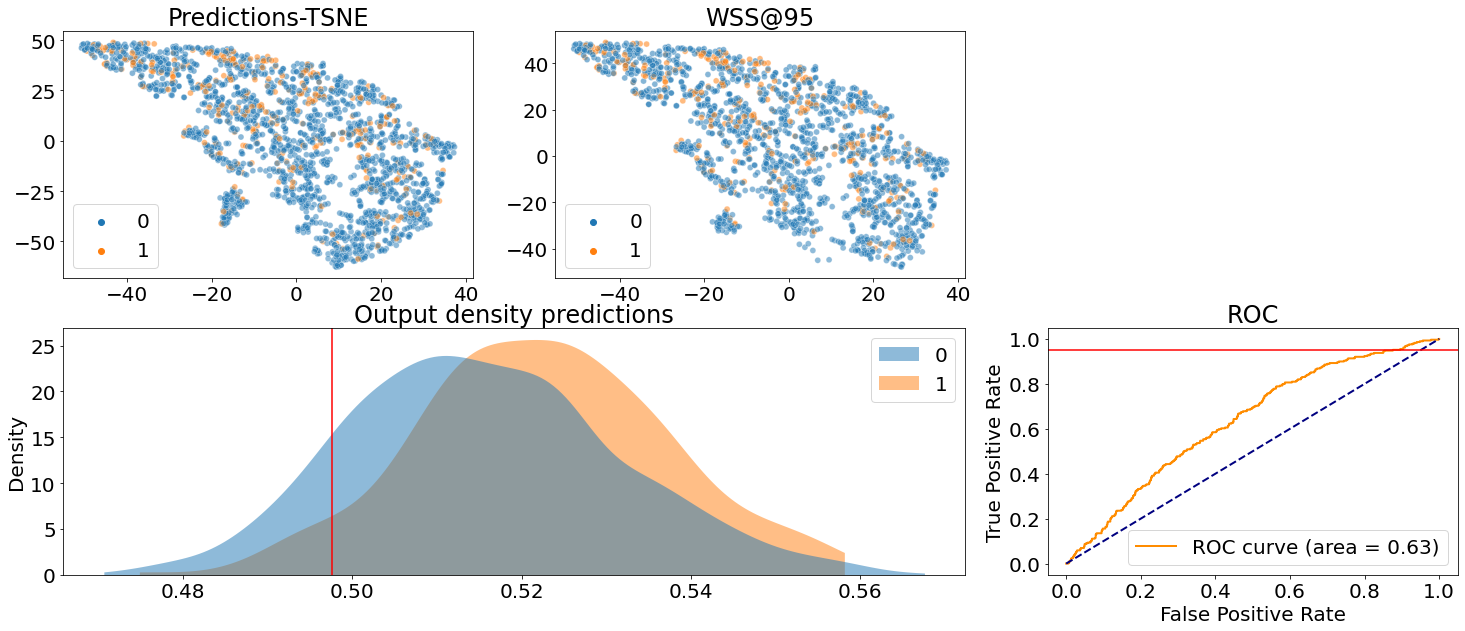

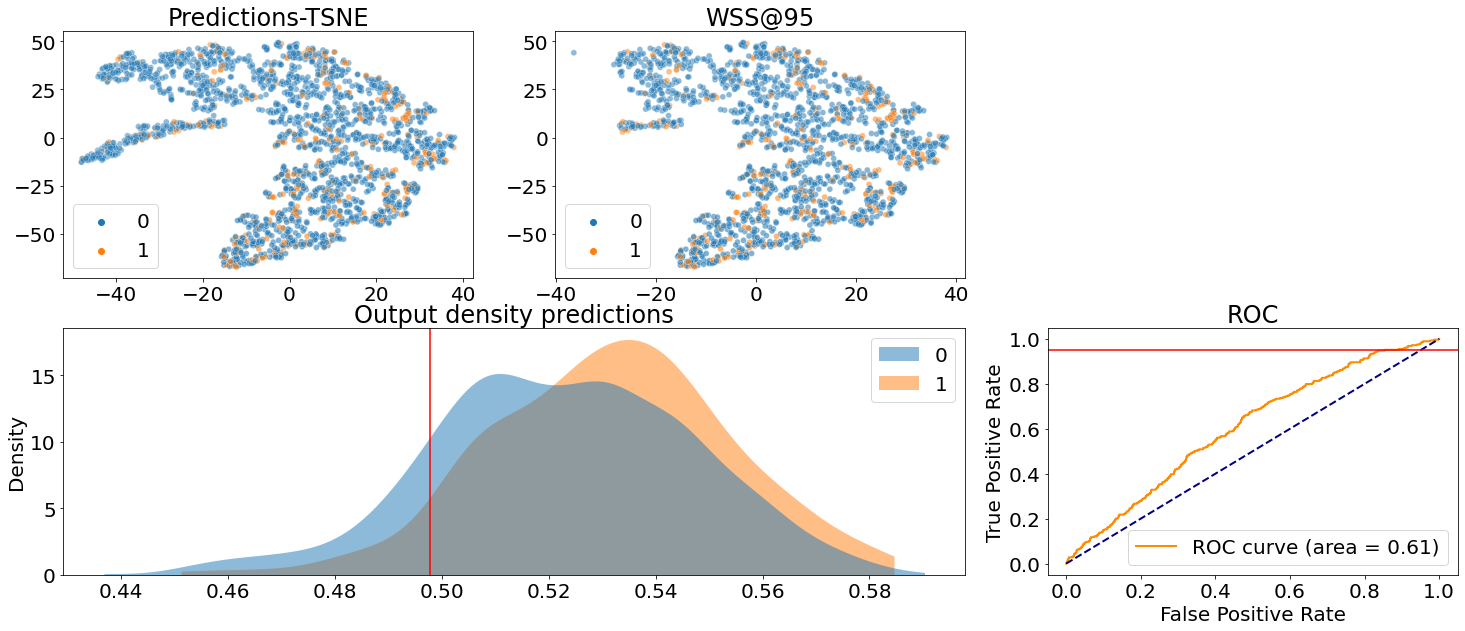

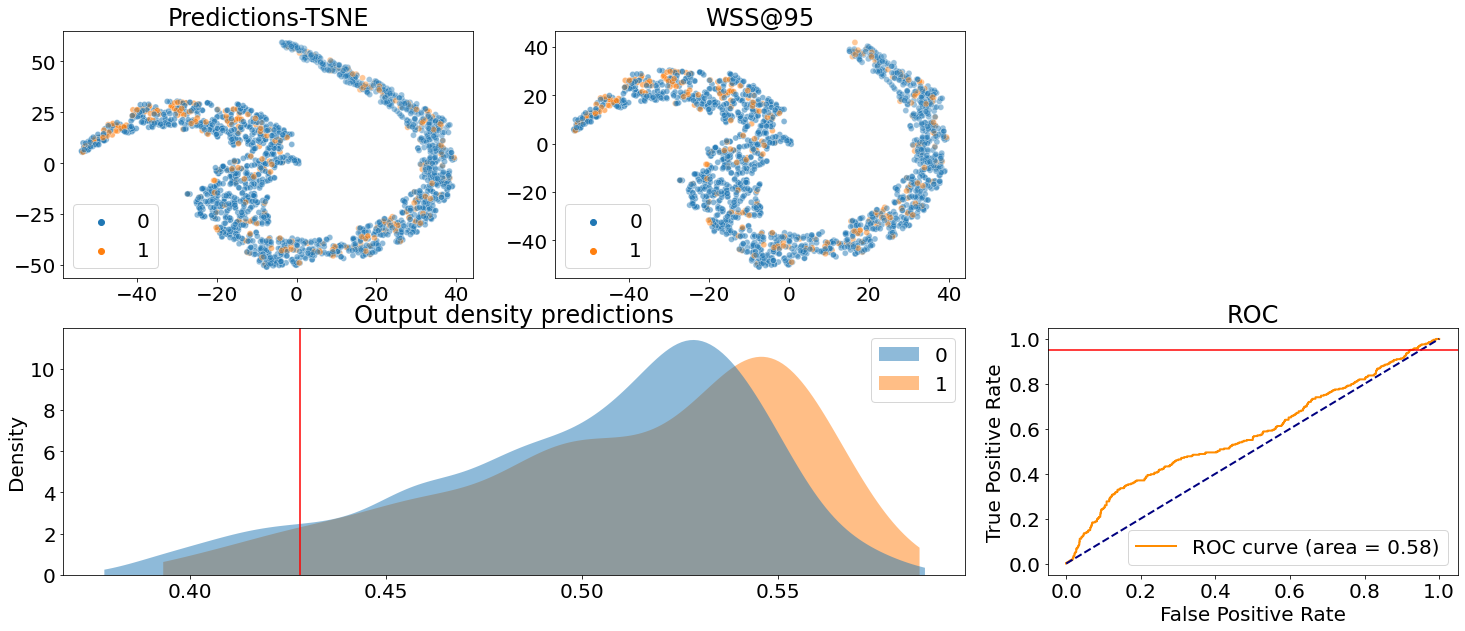

In [ ]:
pipeline_simulation(Valid_resource = cohen_data,
                    names_to_valid = cohen_names,
                    path_save = path_save,
                    model = model, 
                    epochs=[Info['inner_update_step']],
                    Info = Info,
                    treat_text_fun = treat_text_fun,
                    initializer_model = initializer_model,
                    n_attempt=5, batch_test= 100)